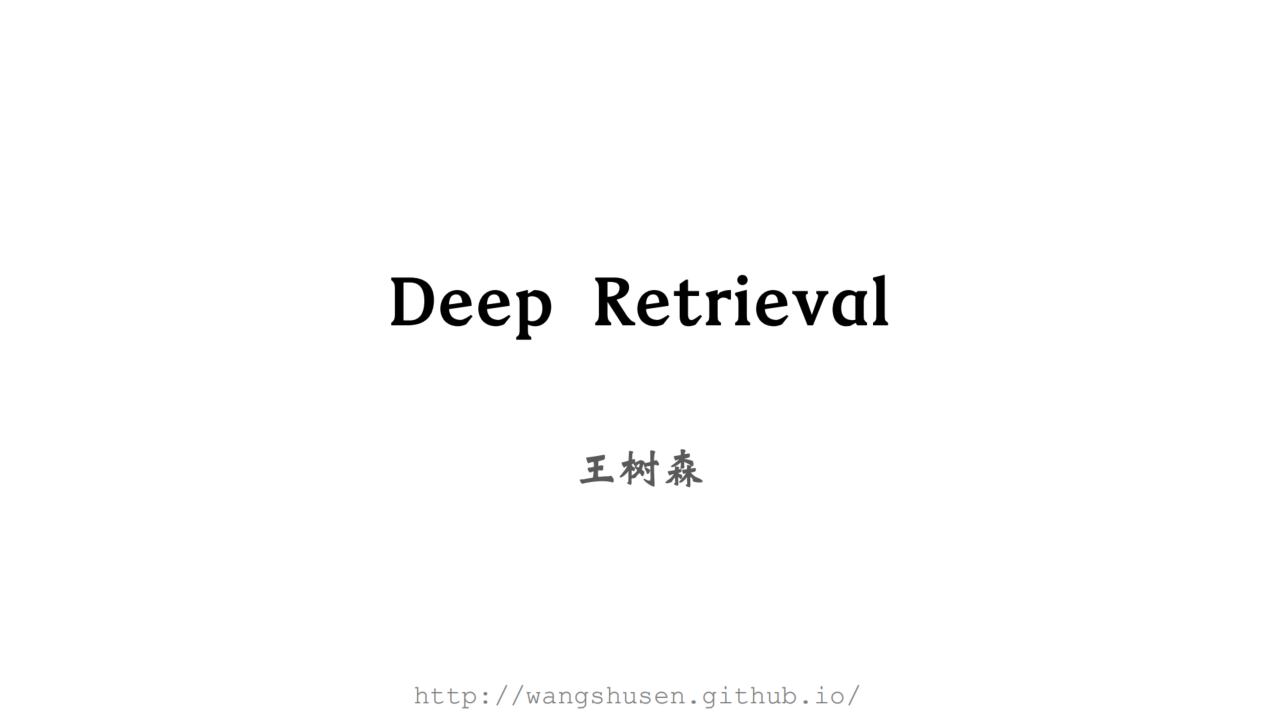

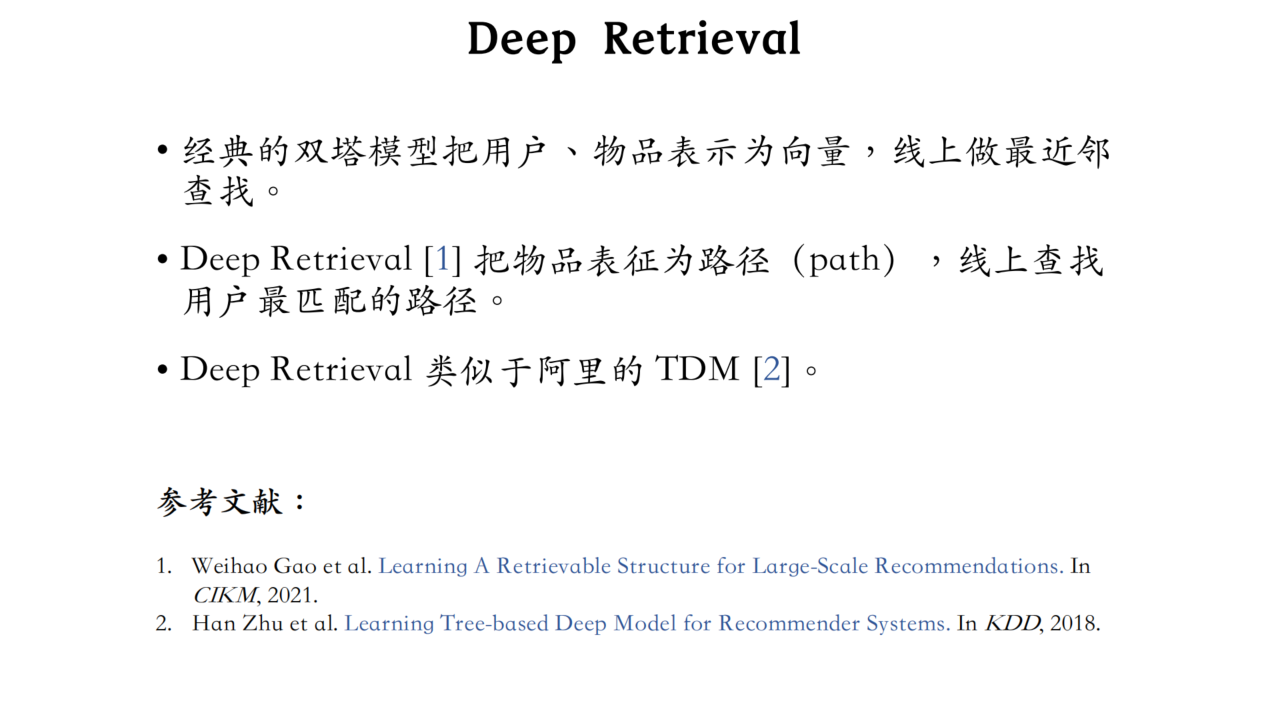

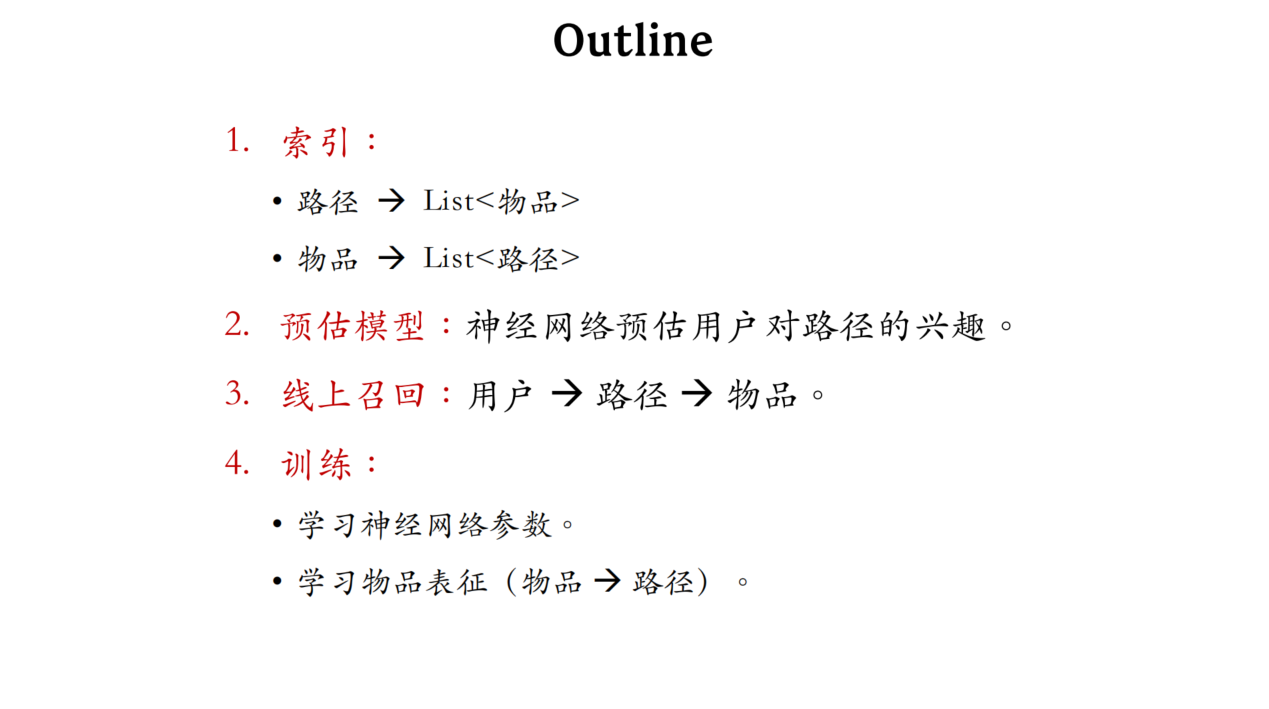

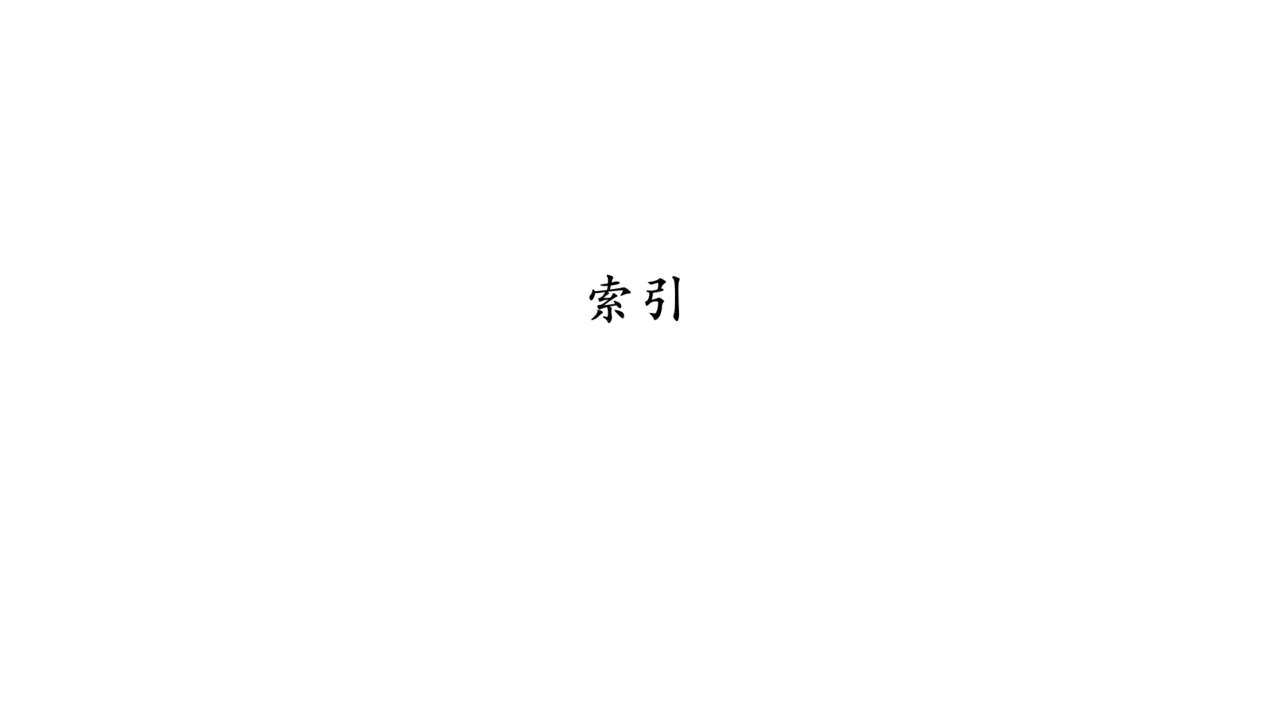

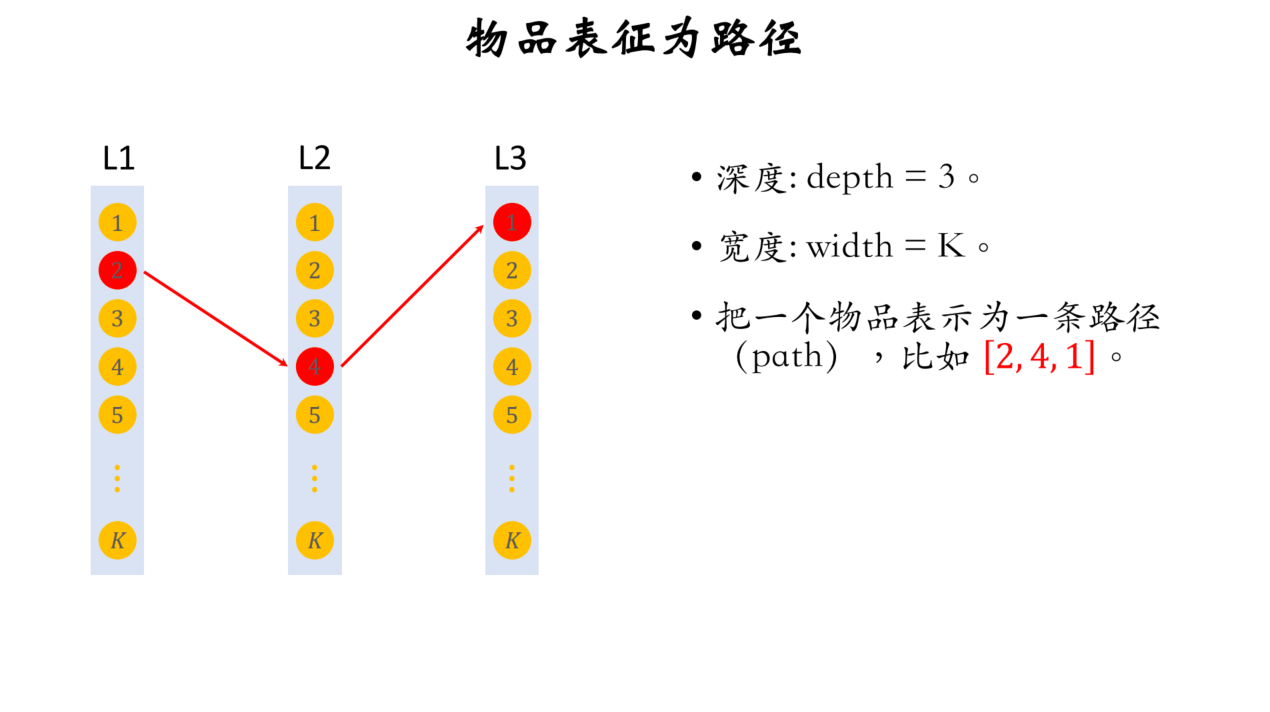

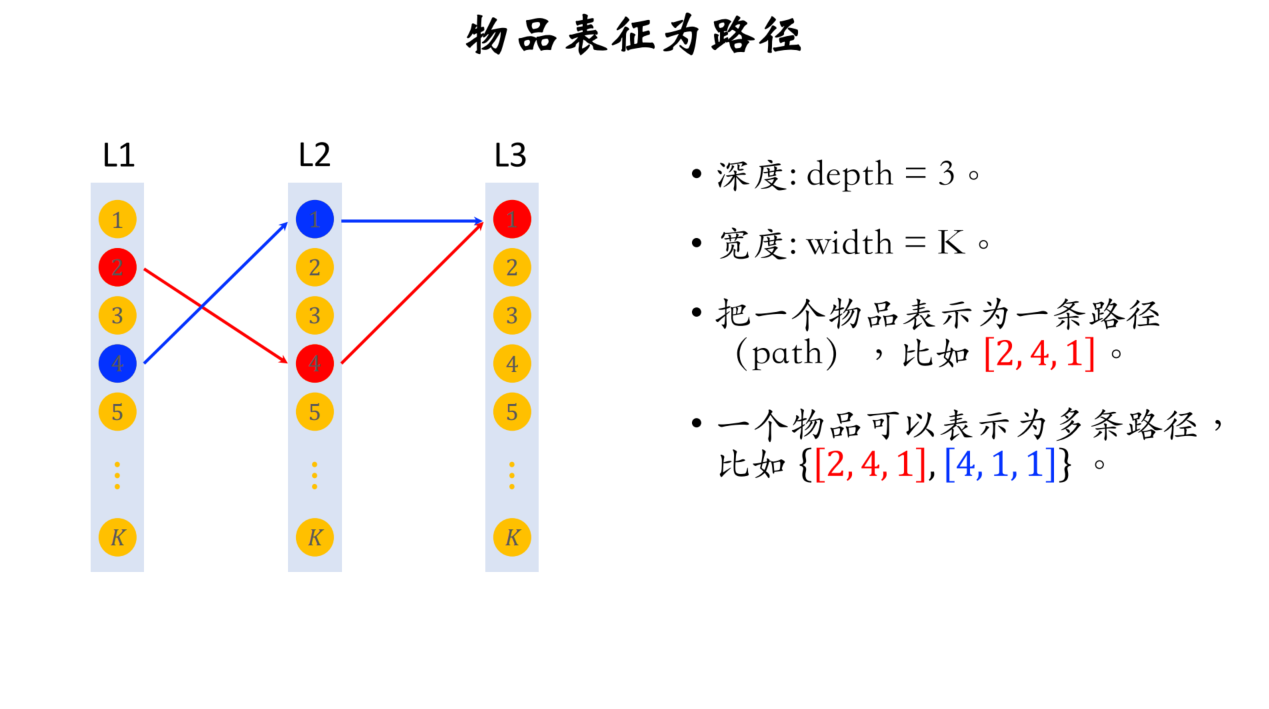  
备注：如果1个batch内不同用户访问同1个节目，那么这个节目就会有2个路径。  

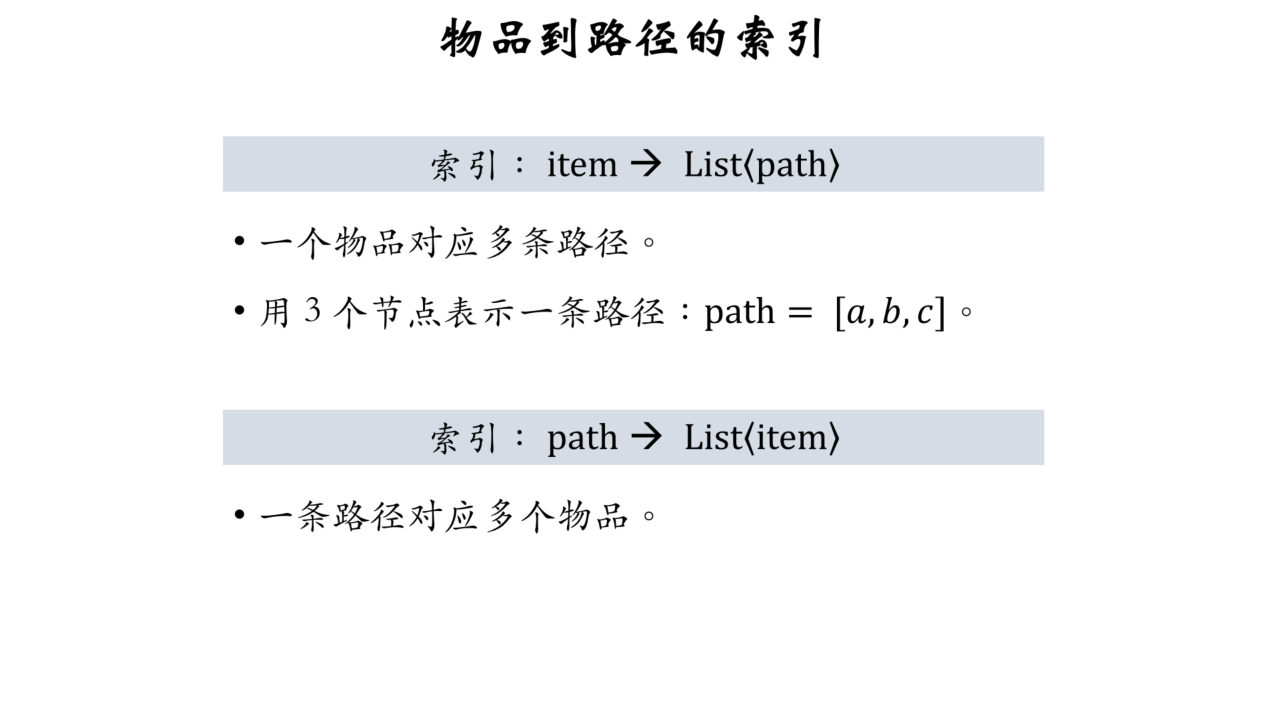

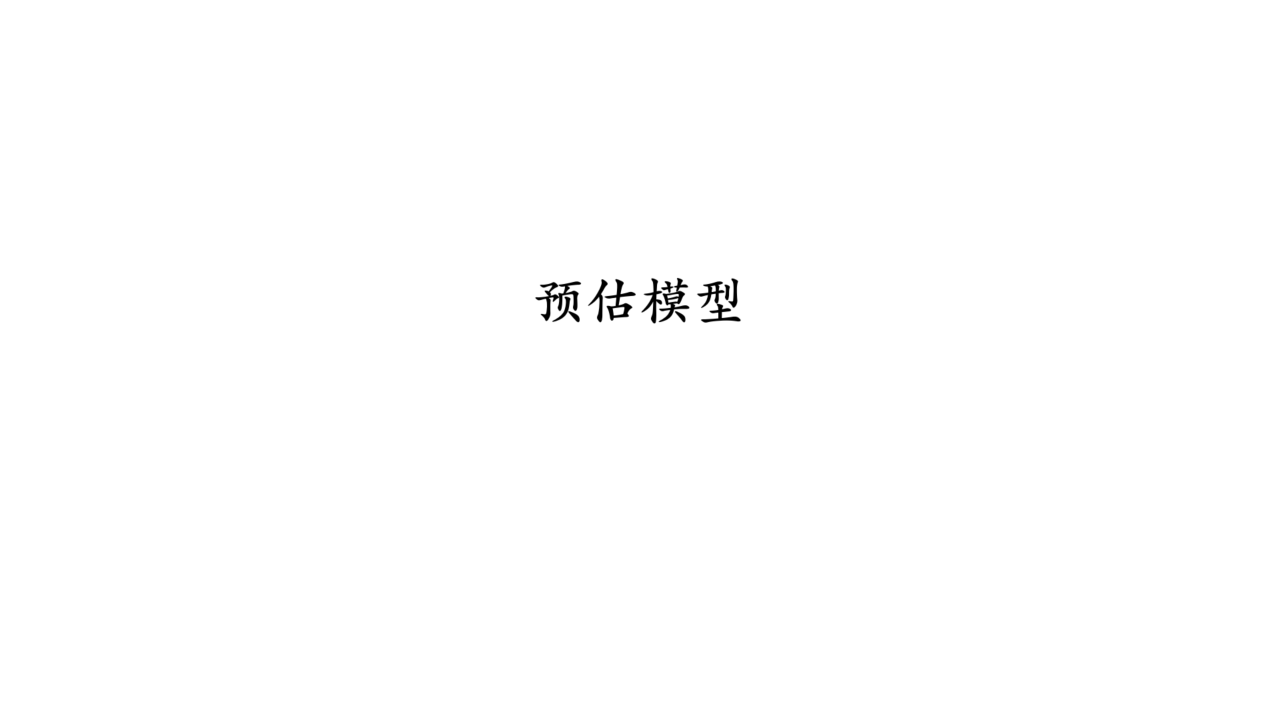

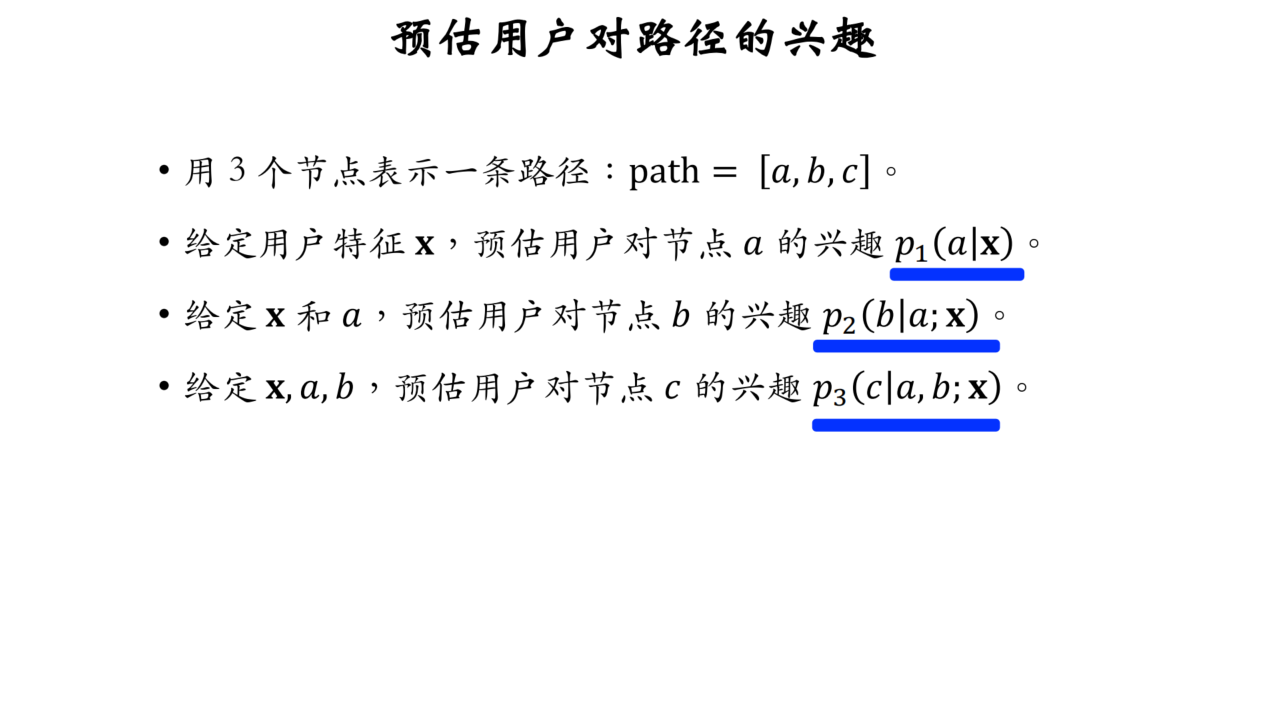

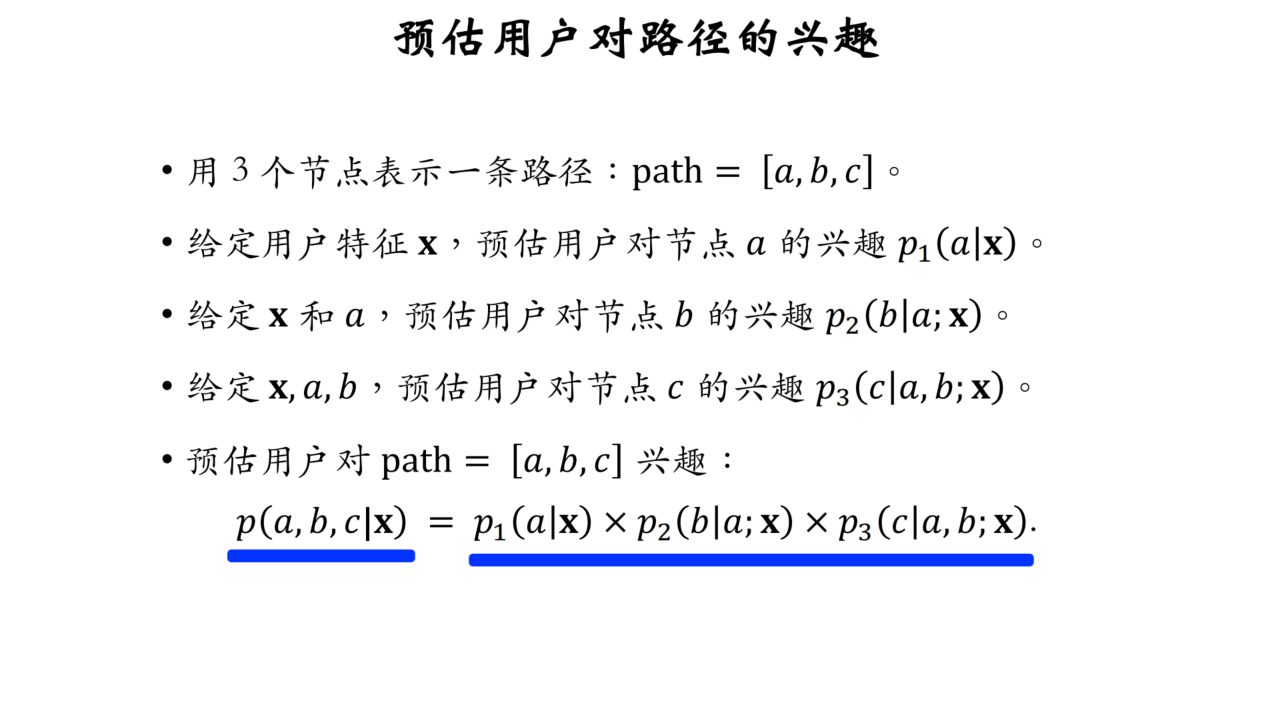

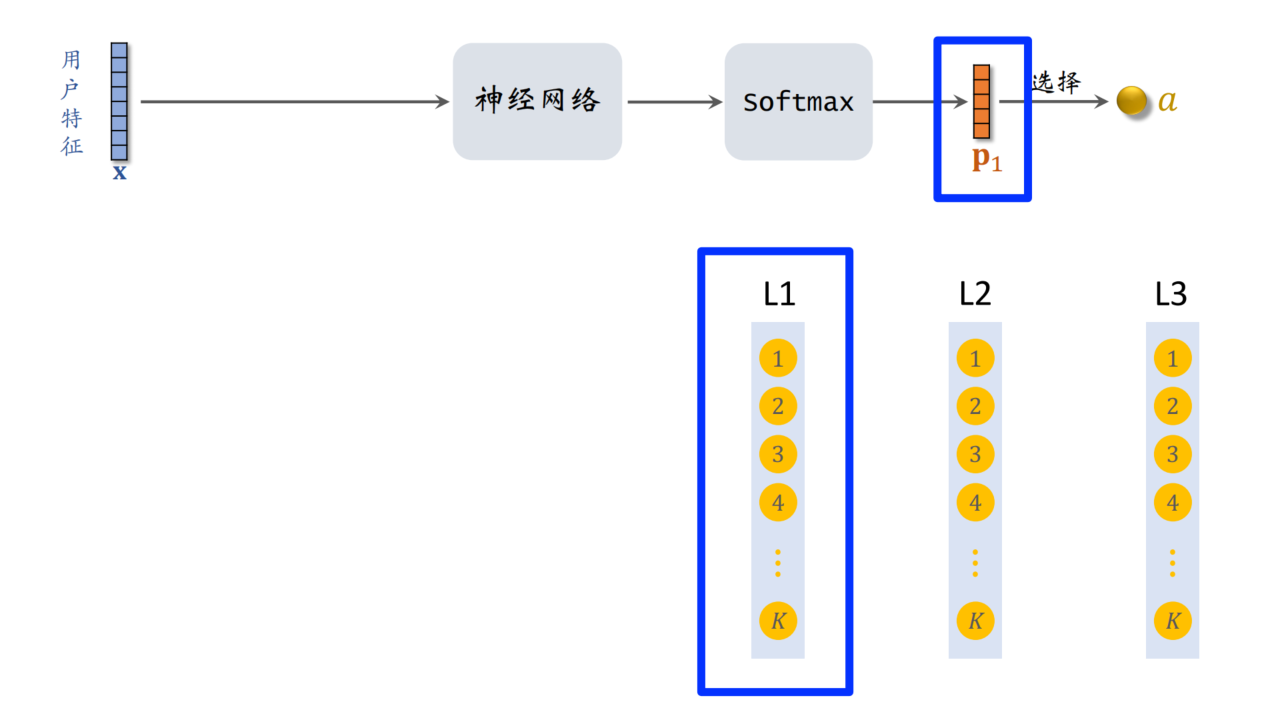

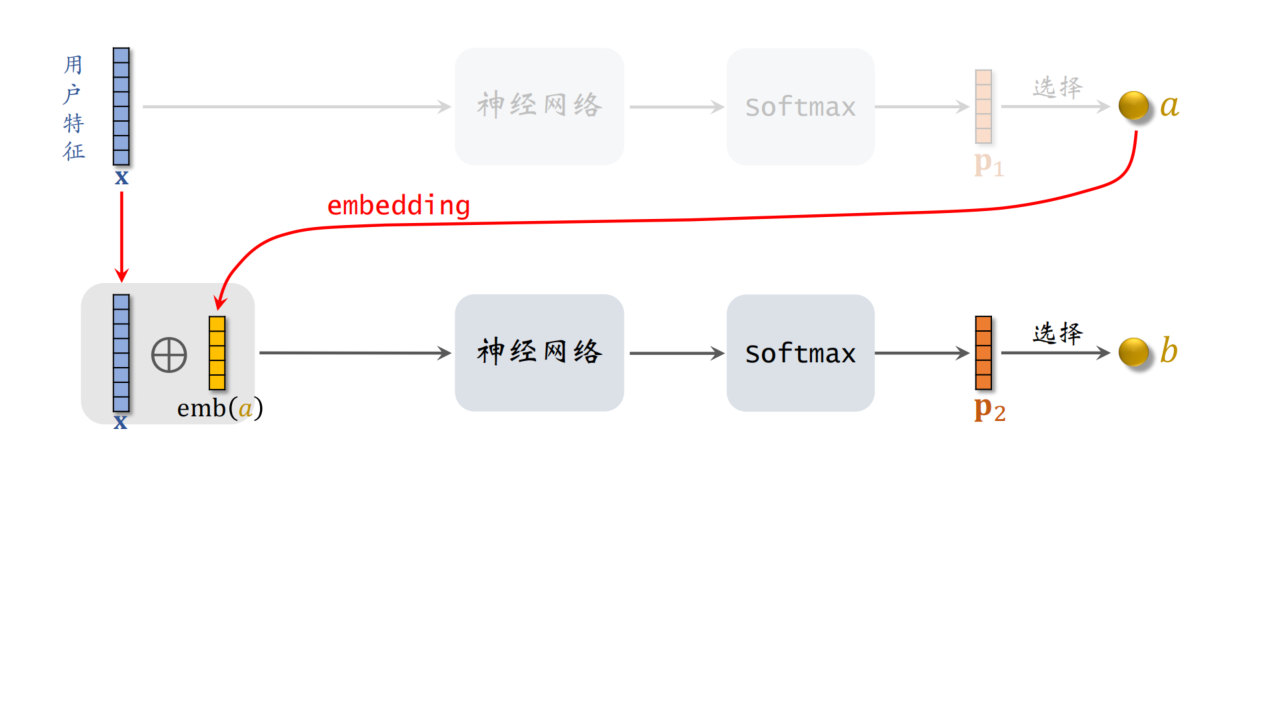

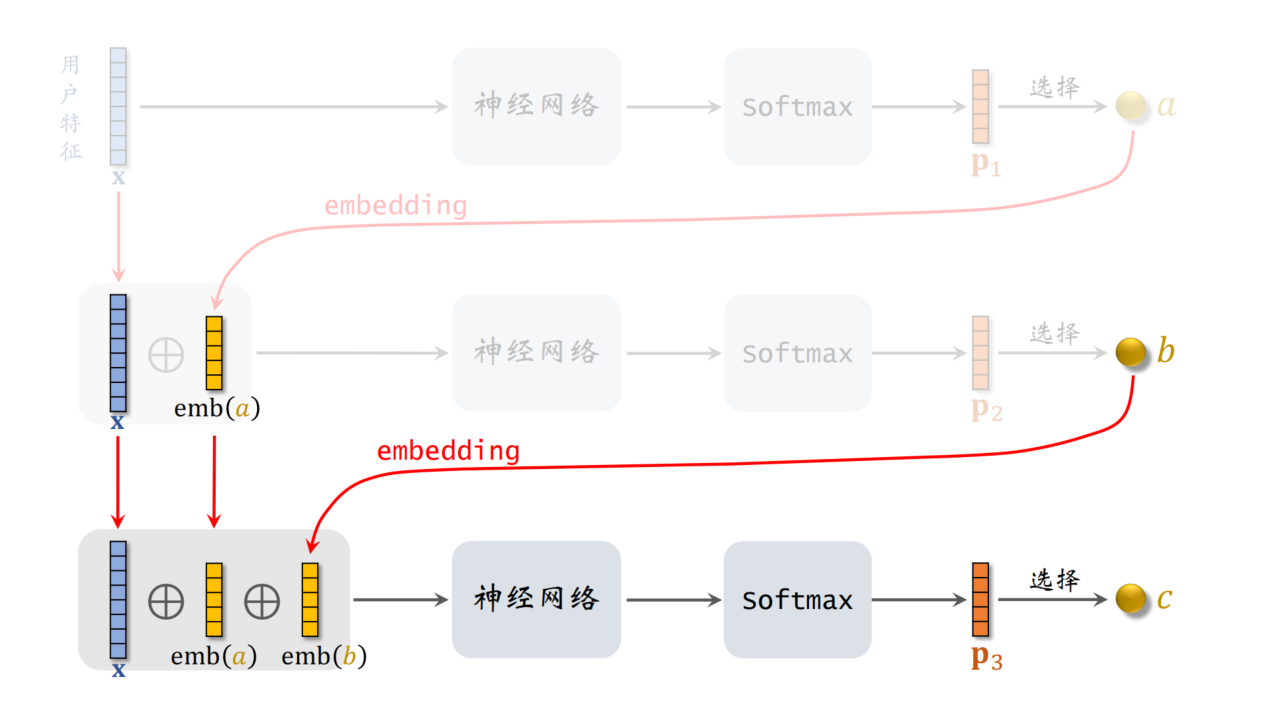

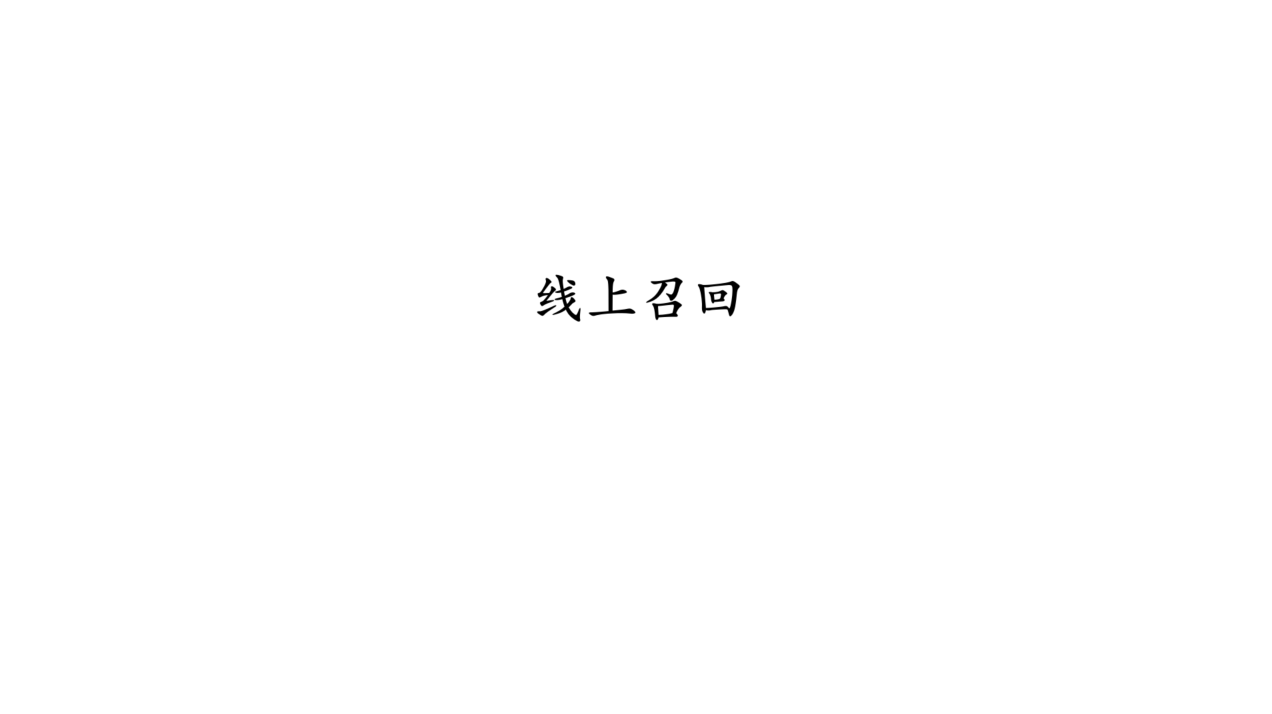

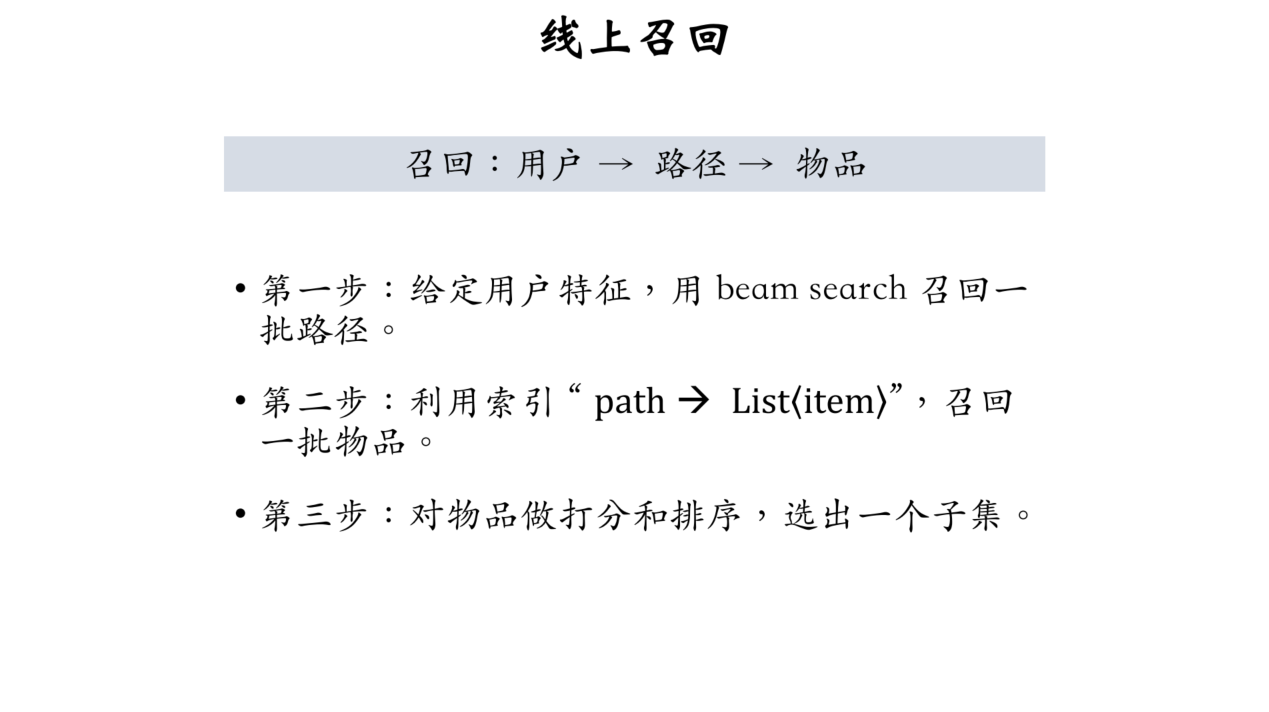

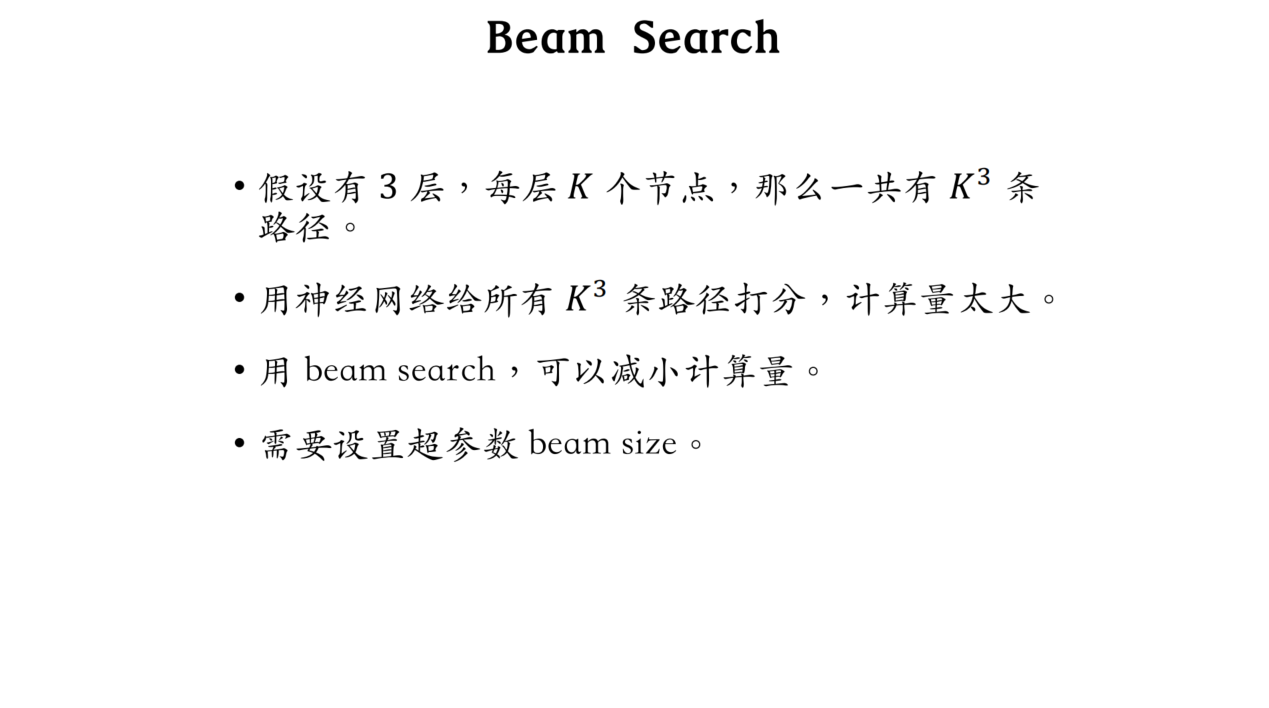

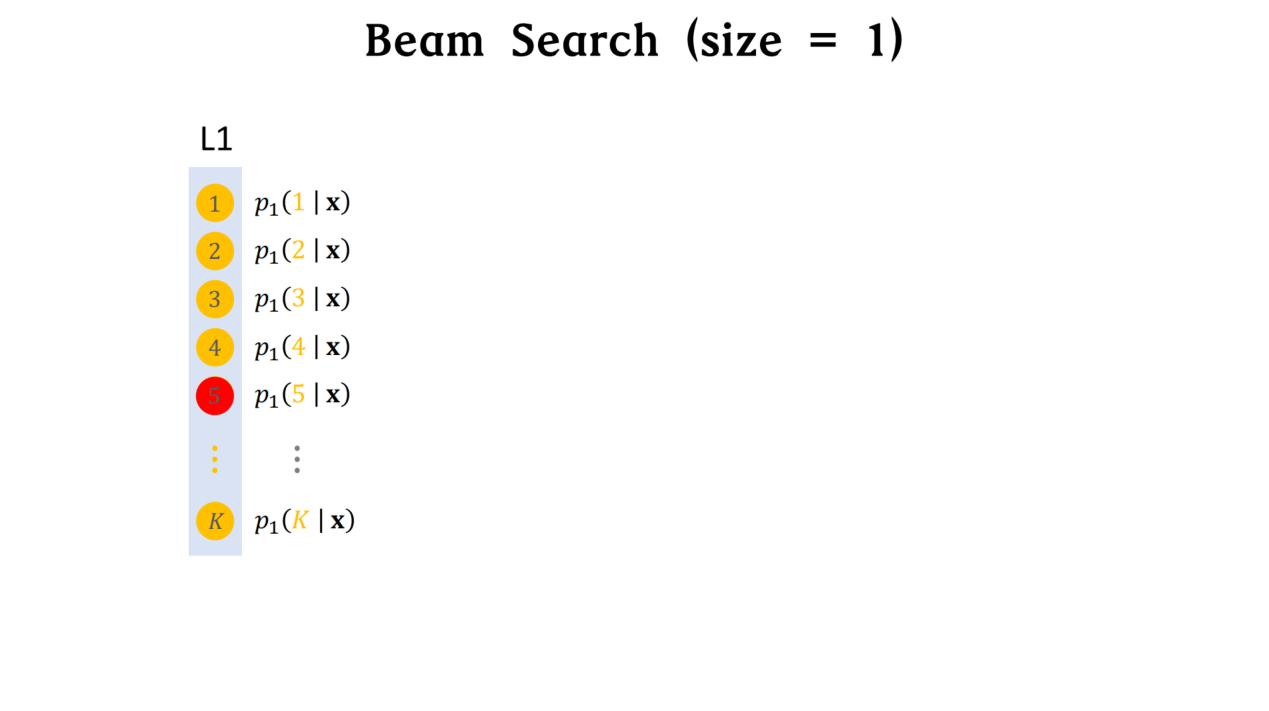

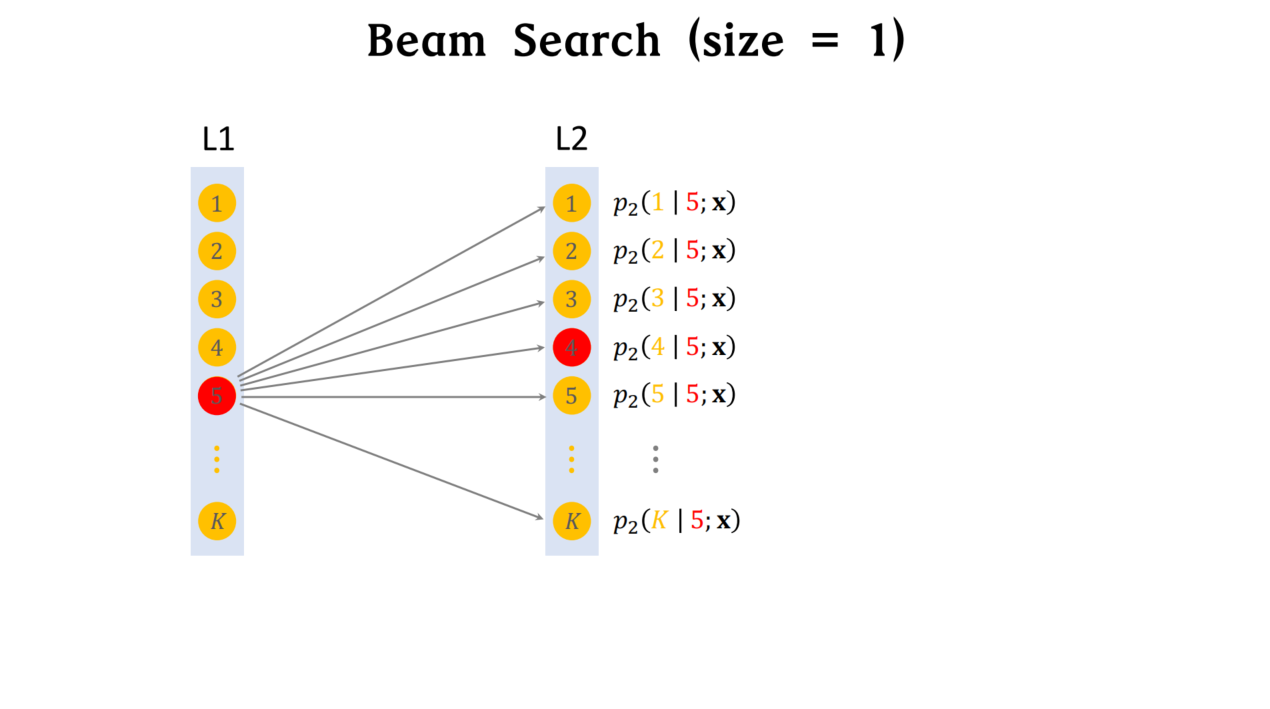

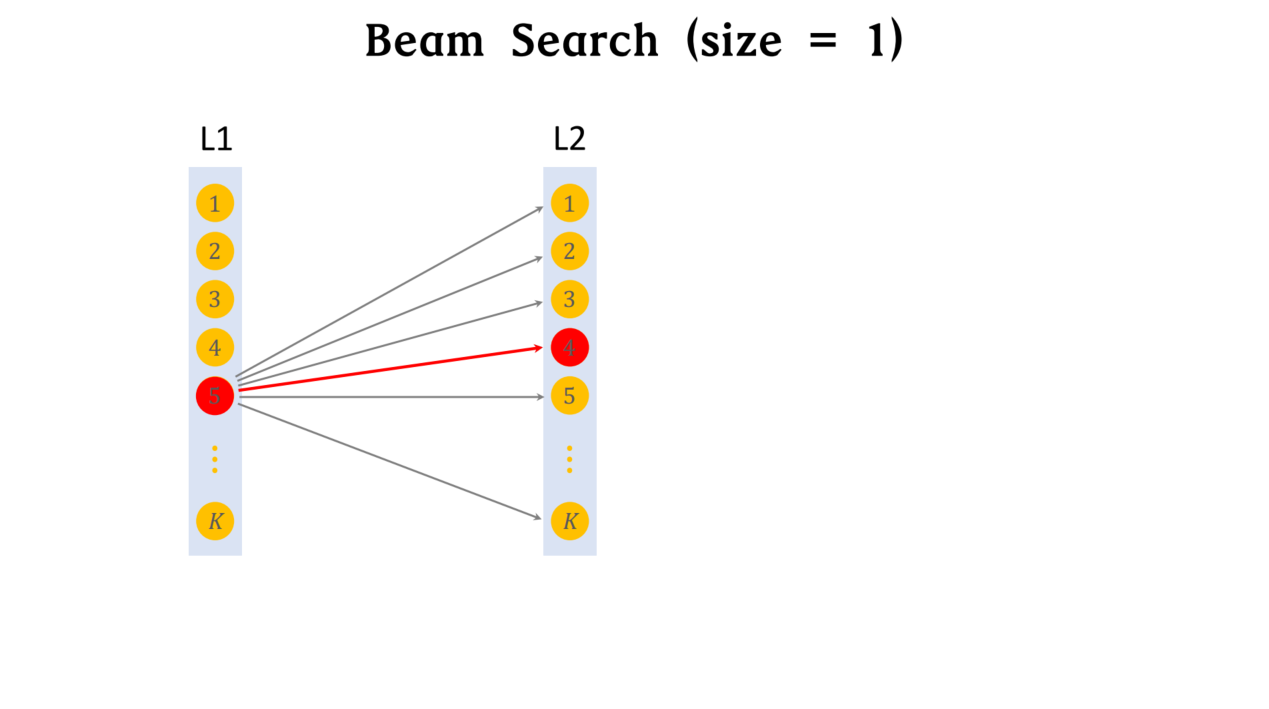

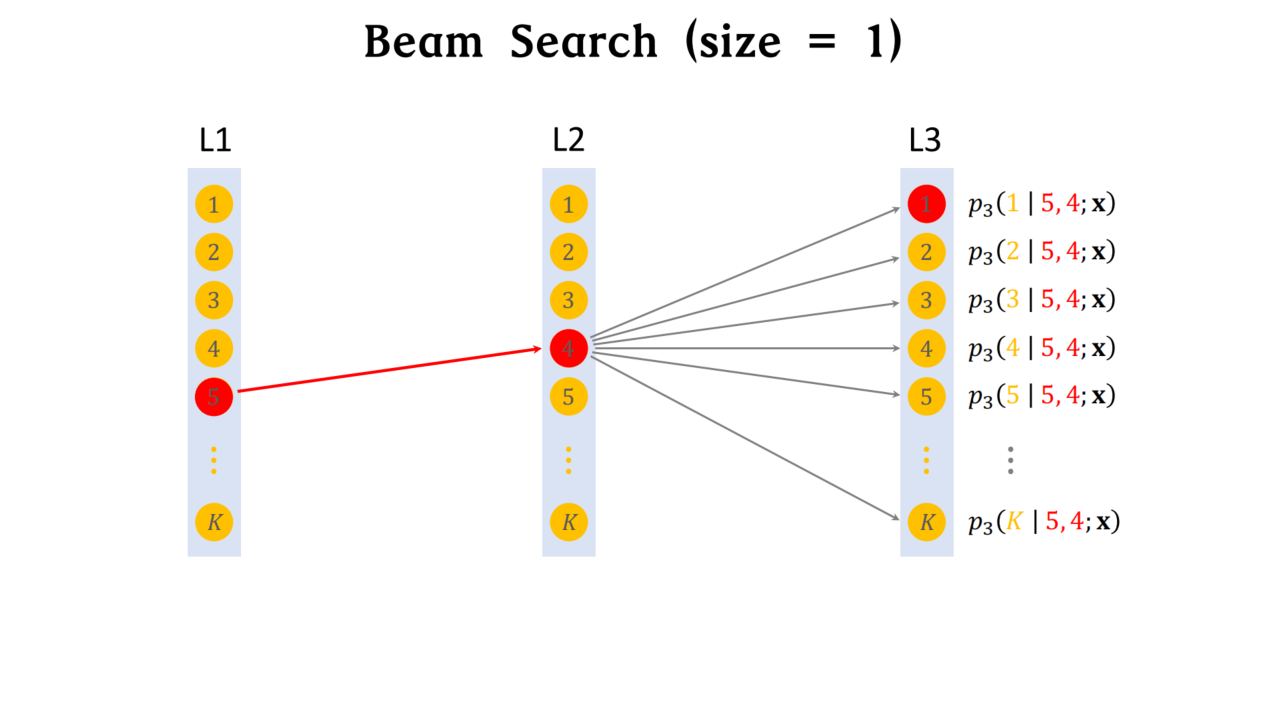

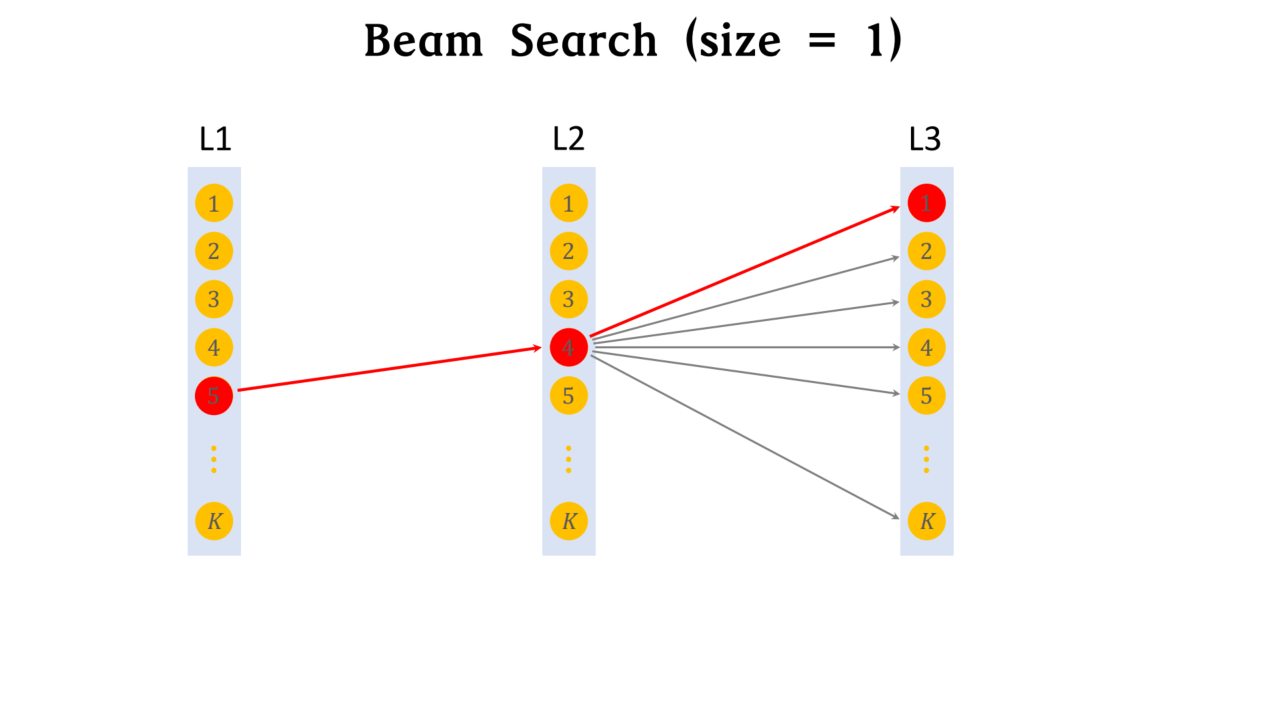

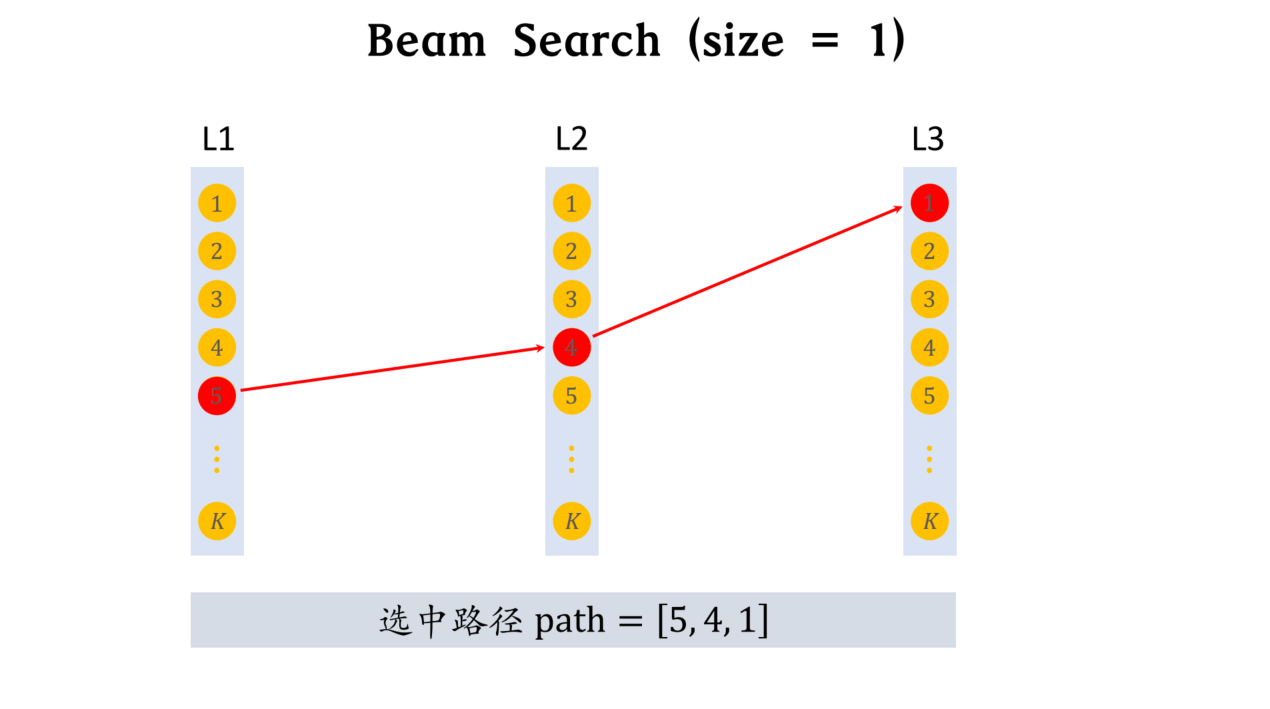

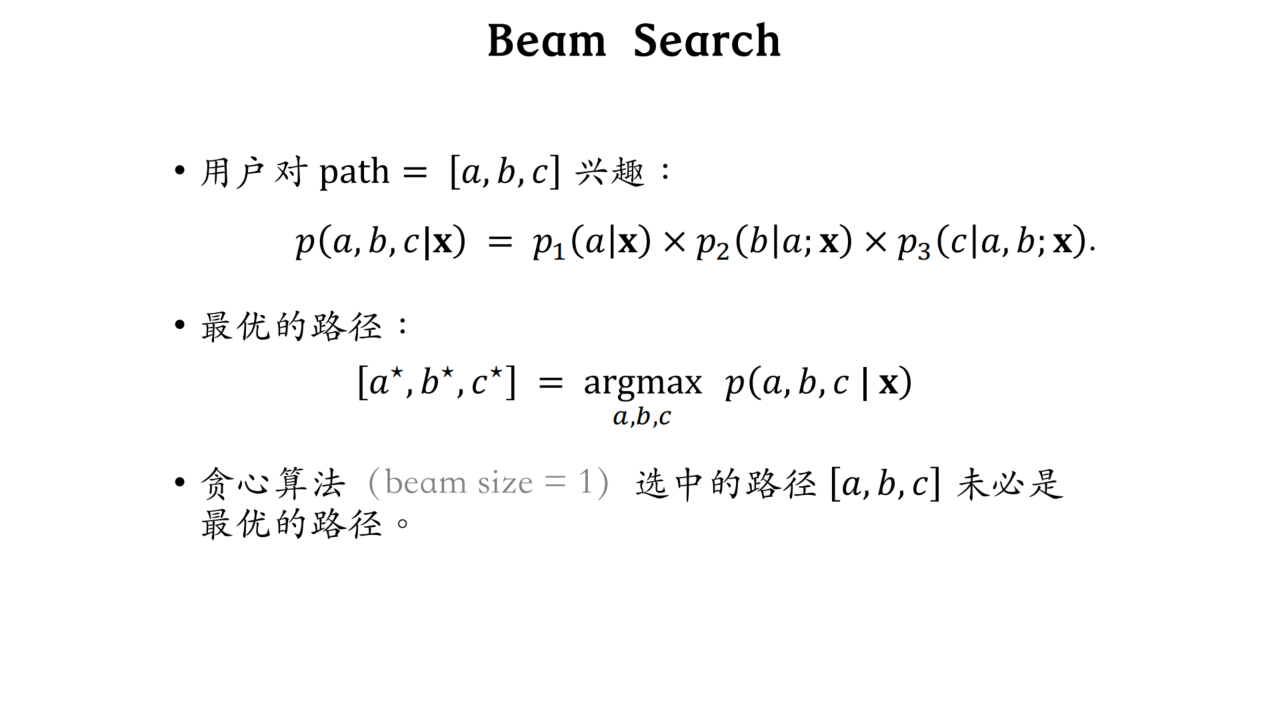

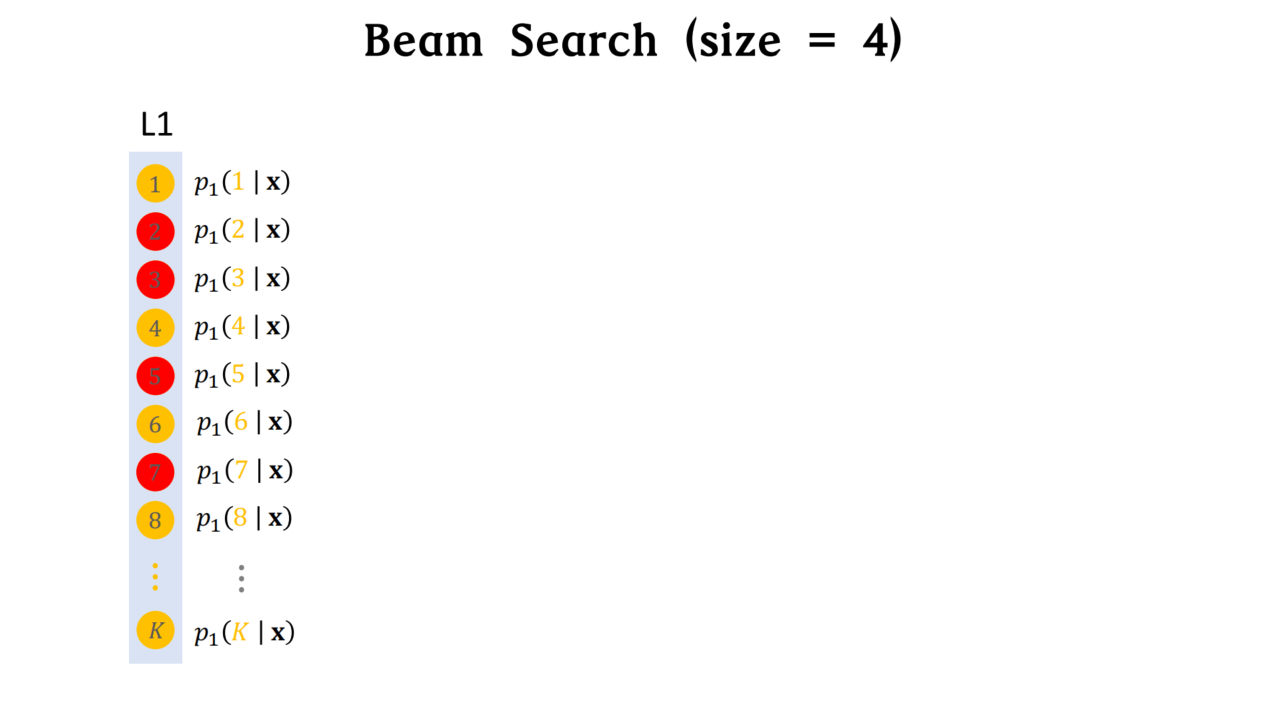

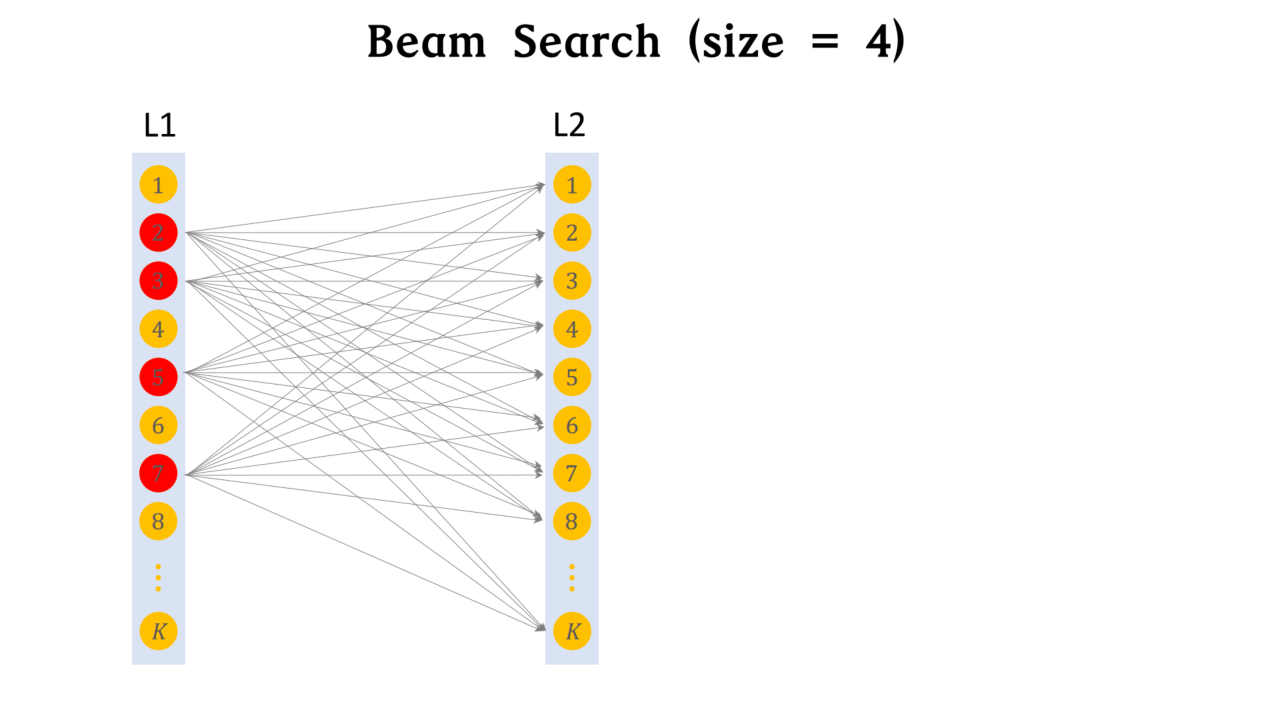

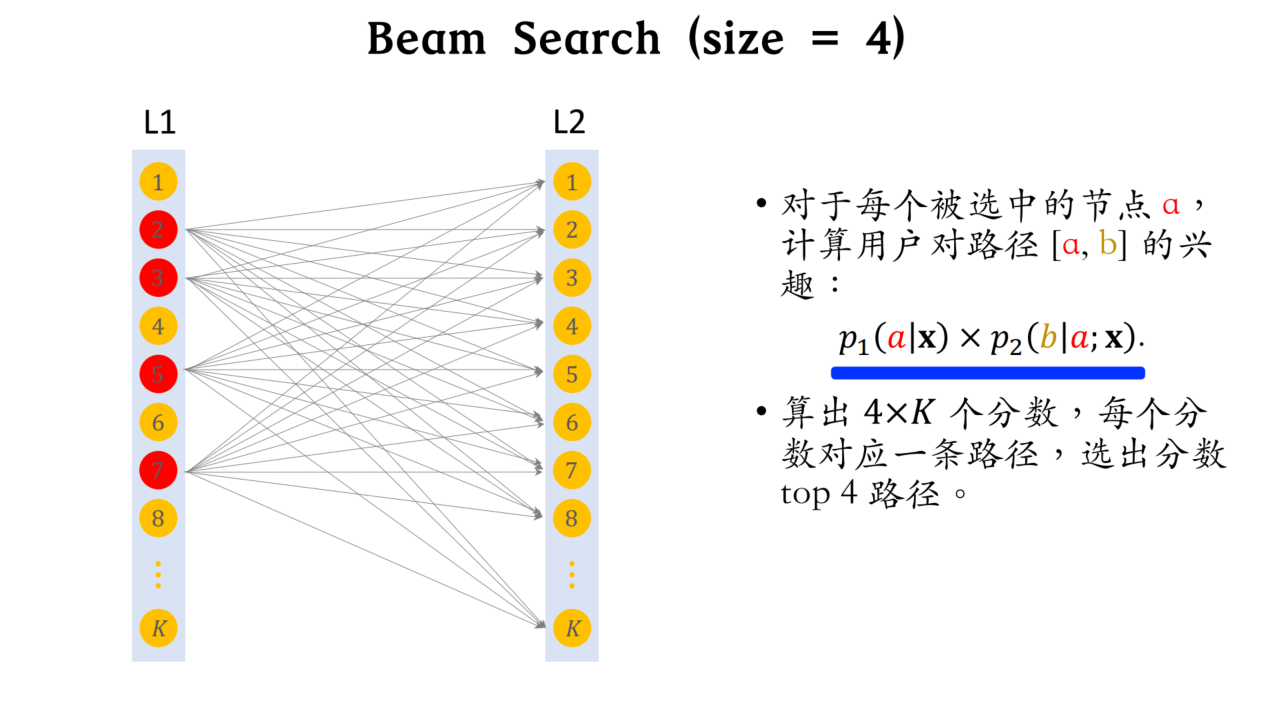

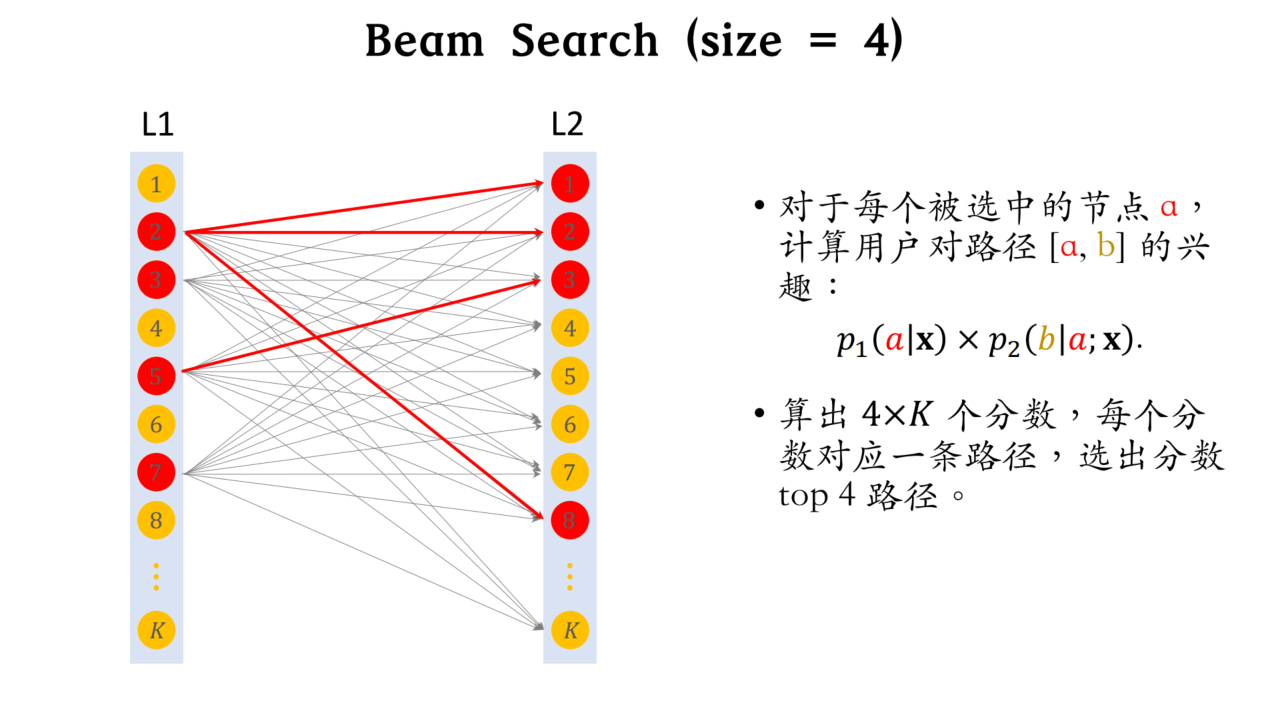

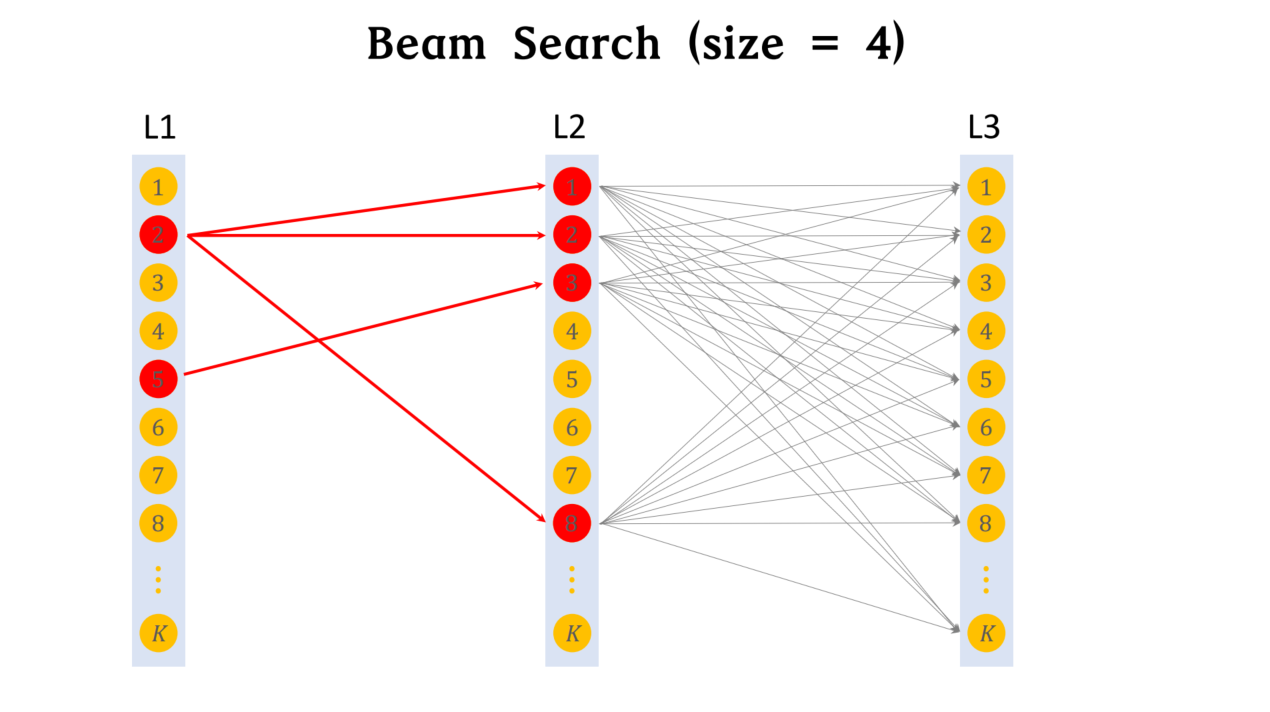

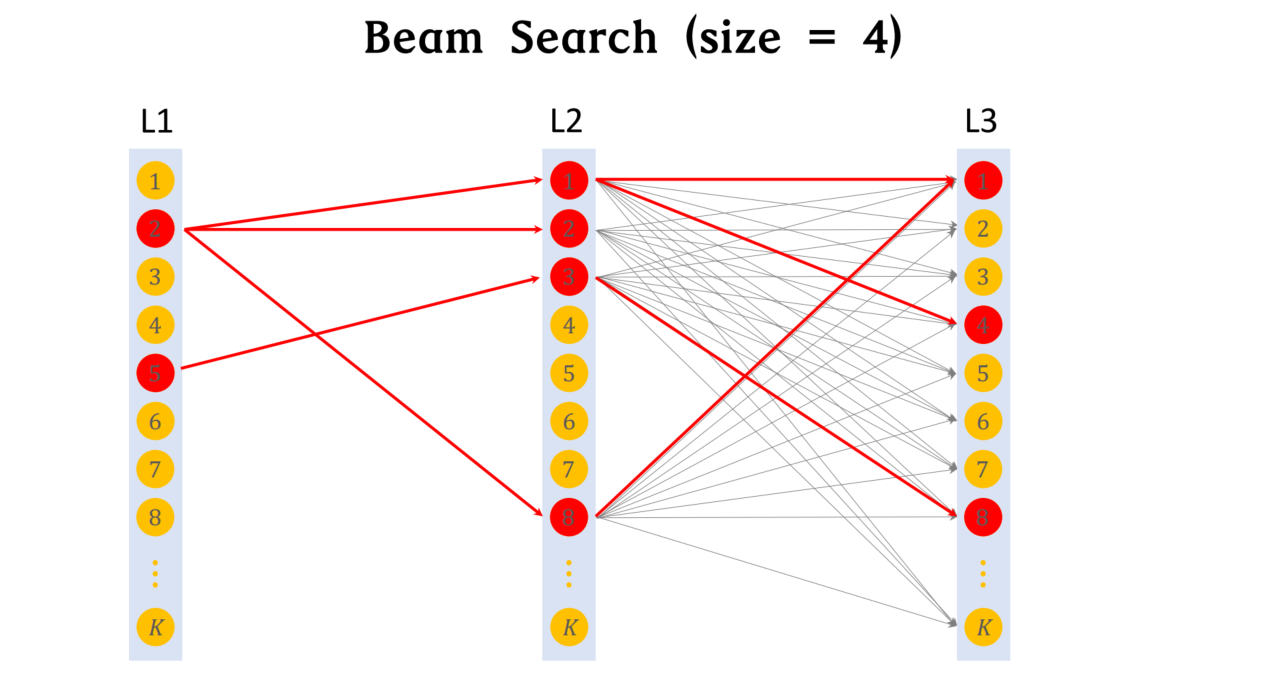

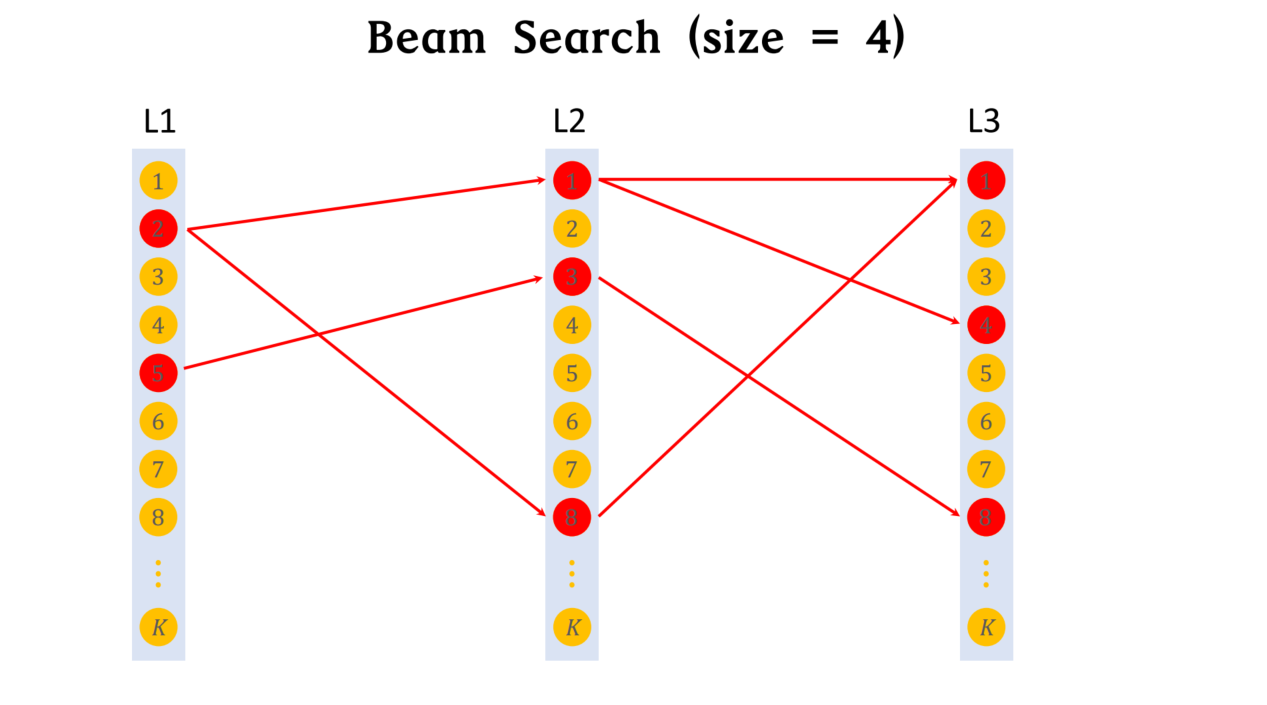

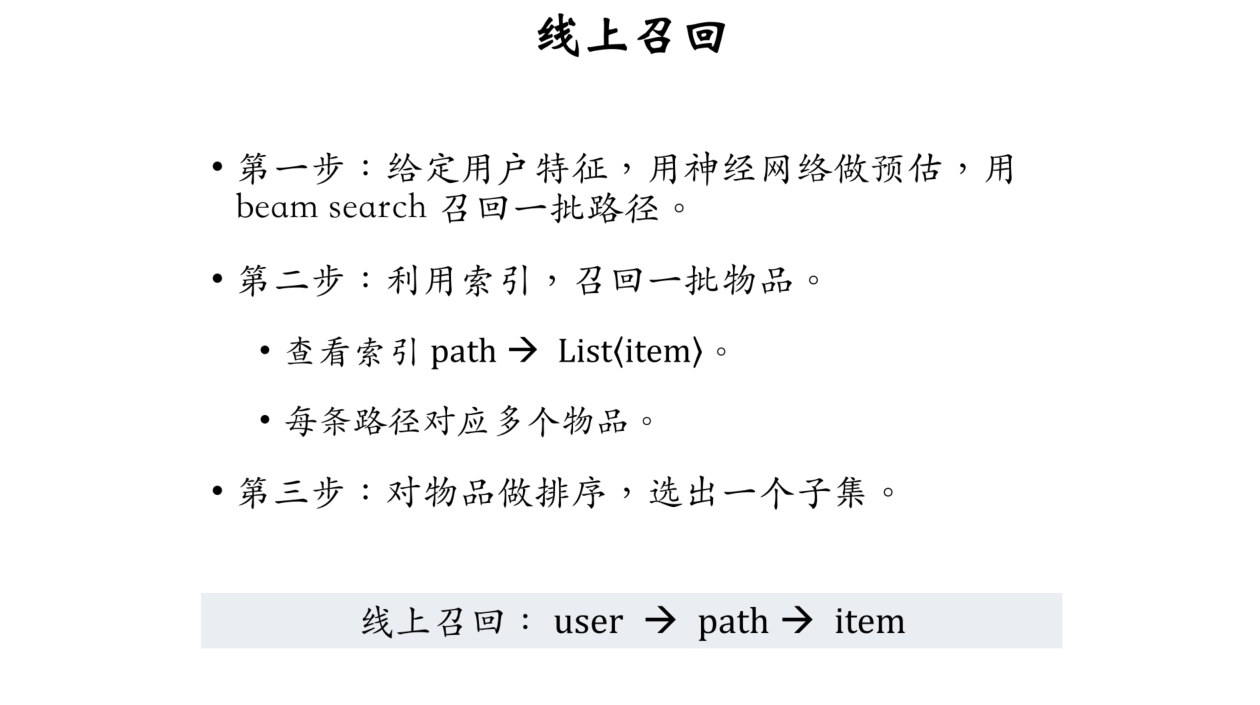

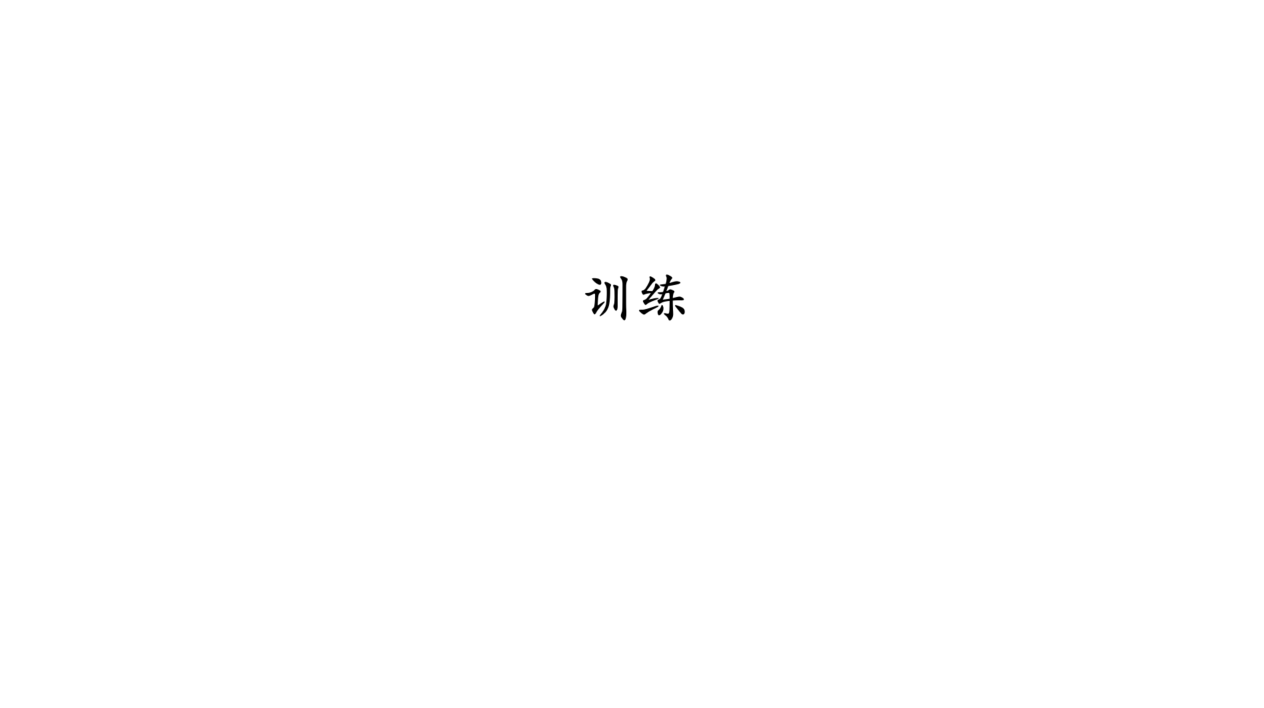

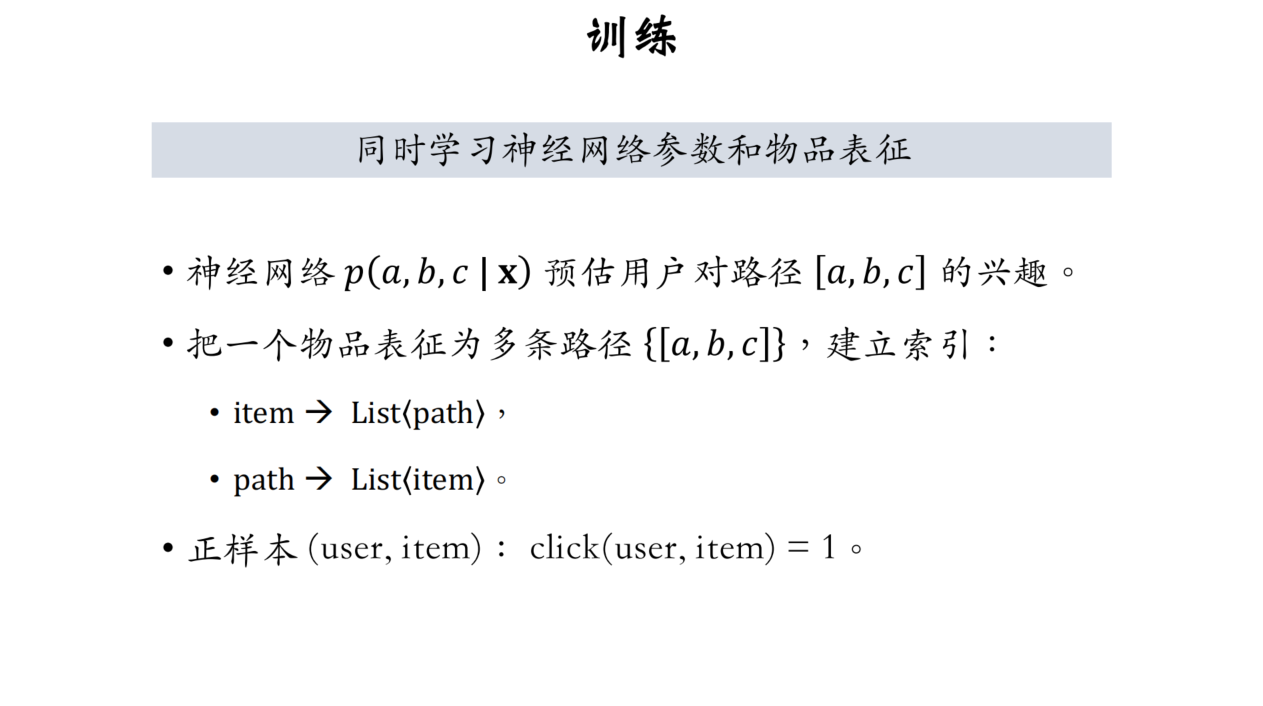

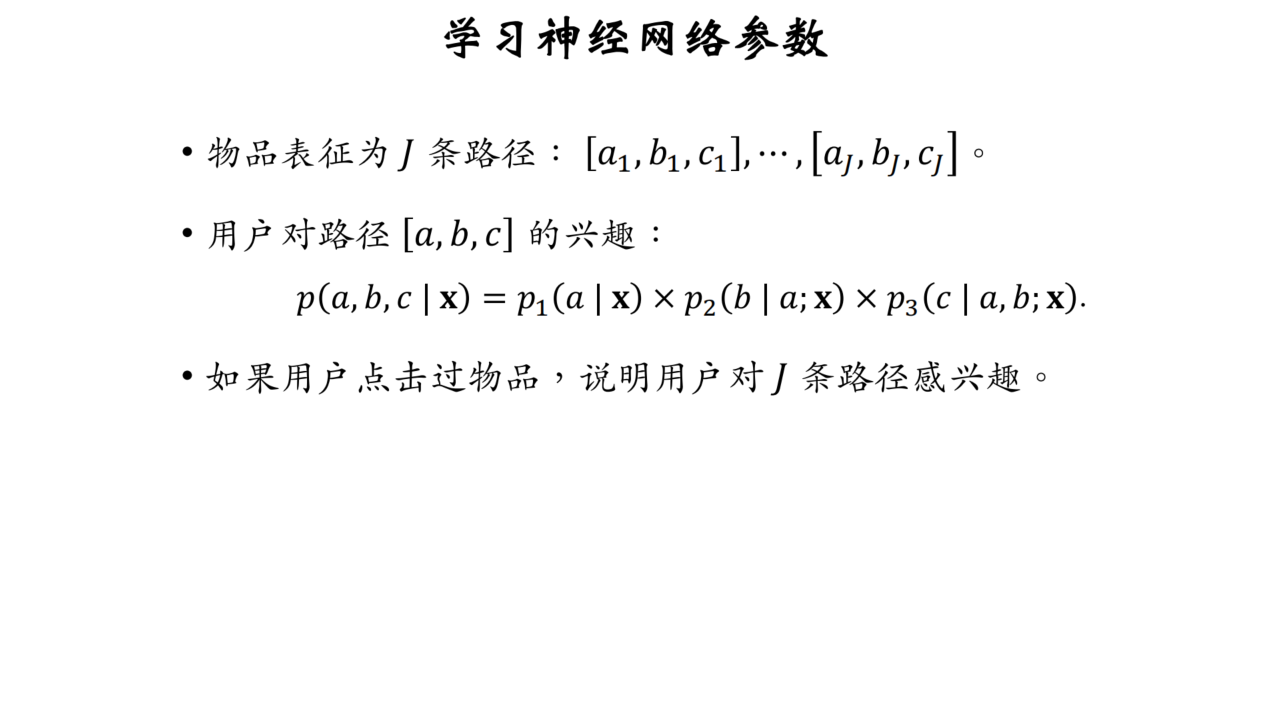

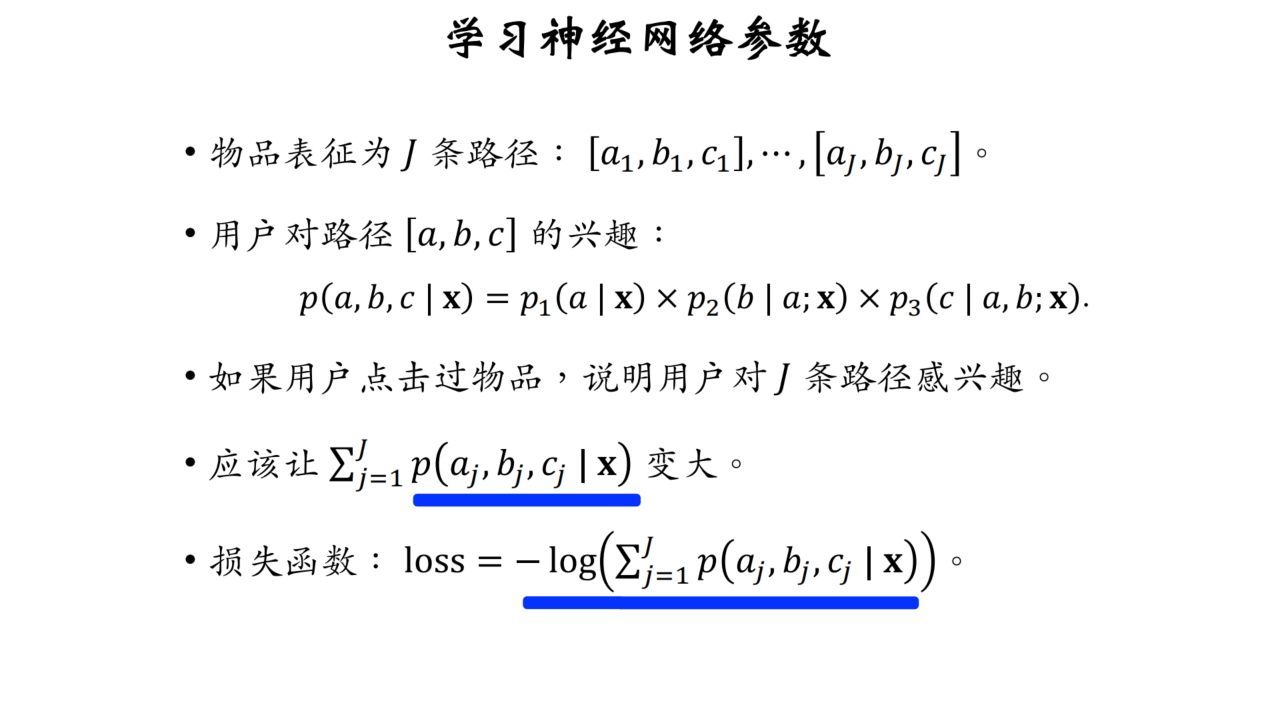

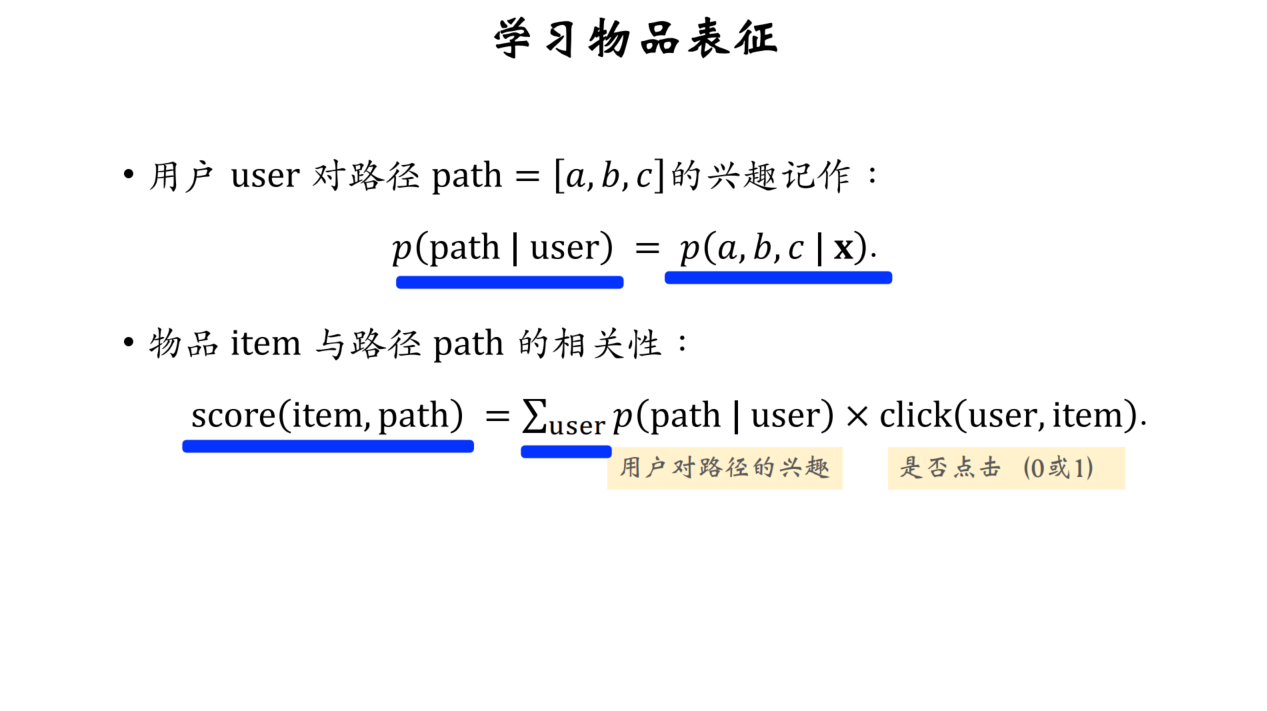

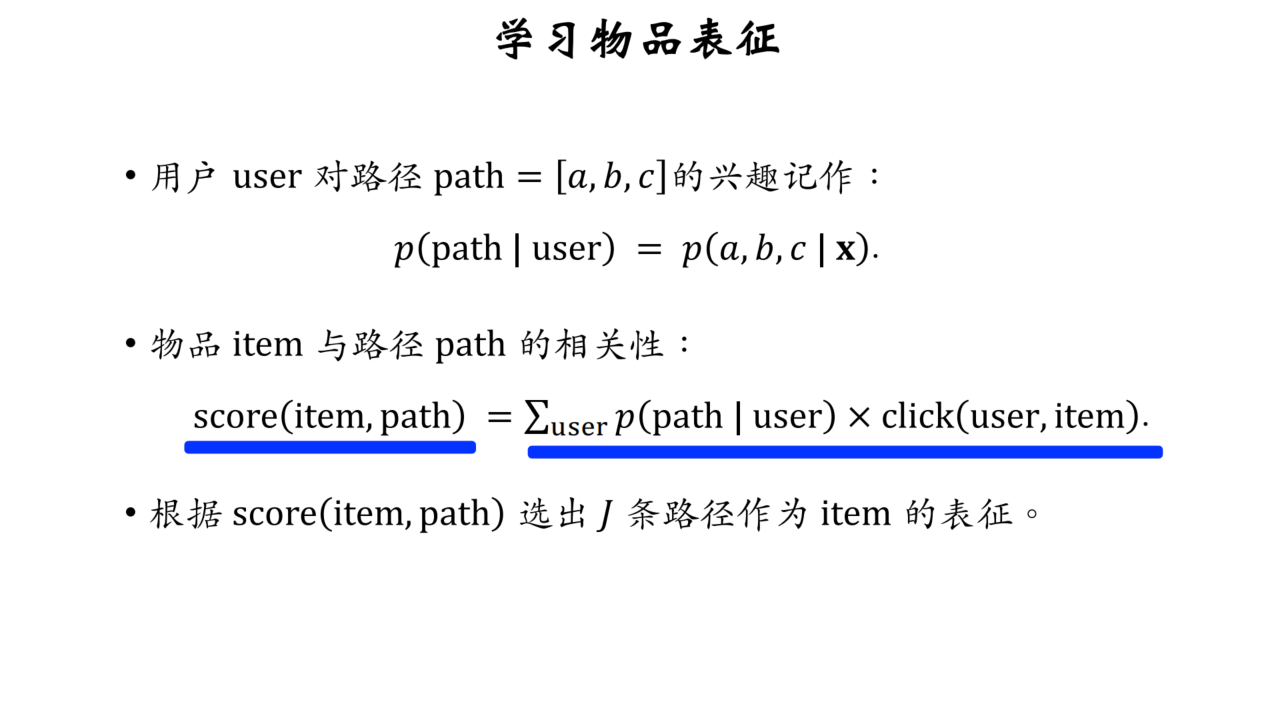

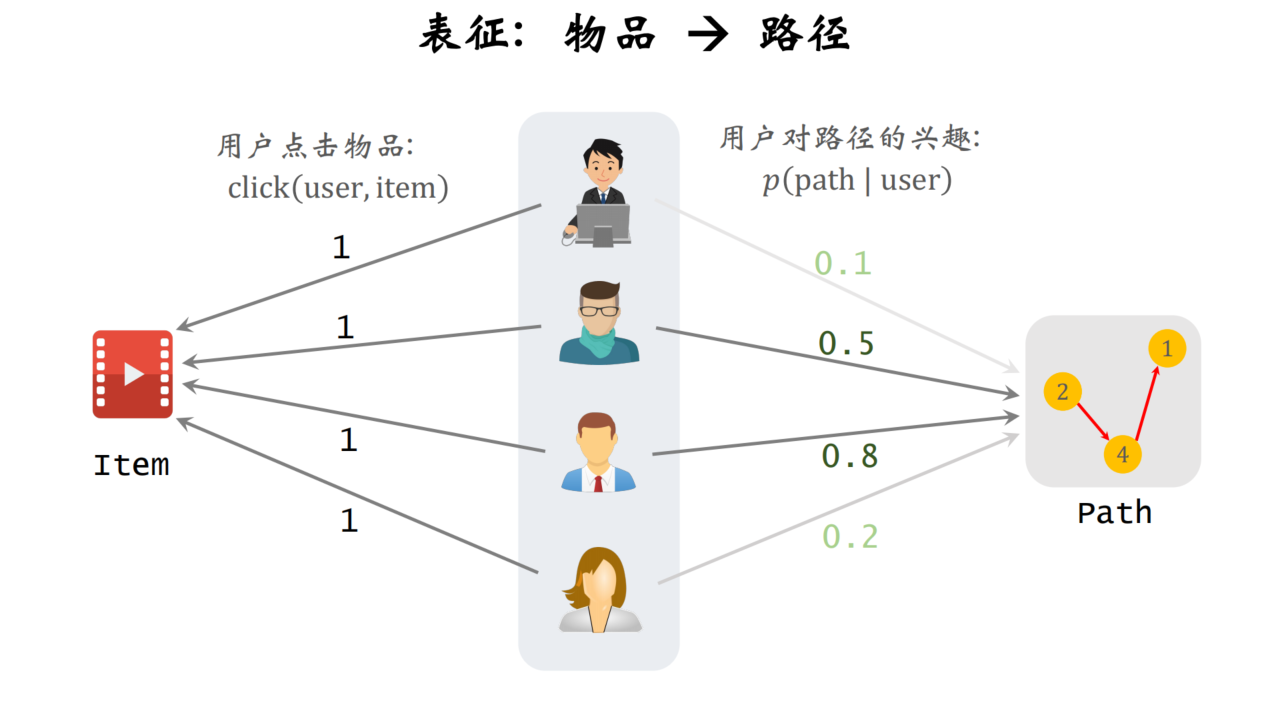

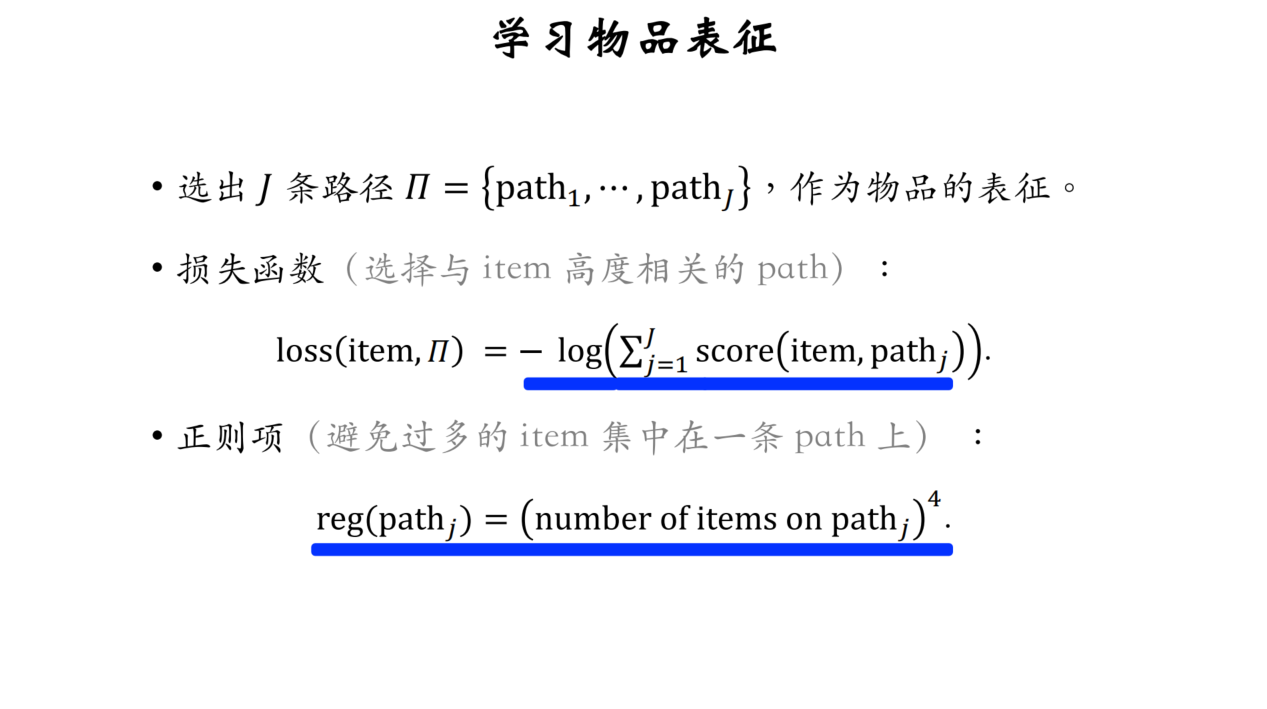

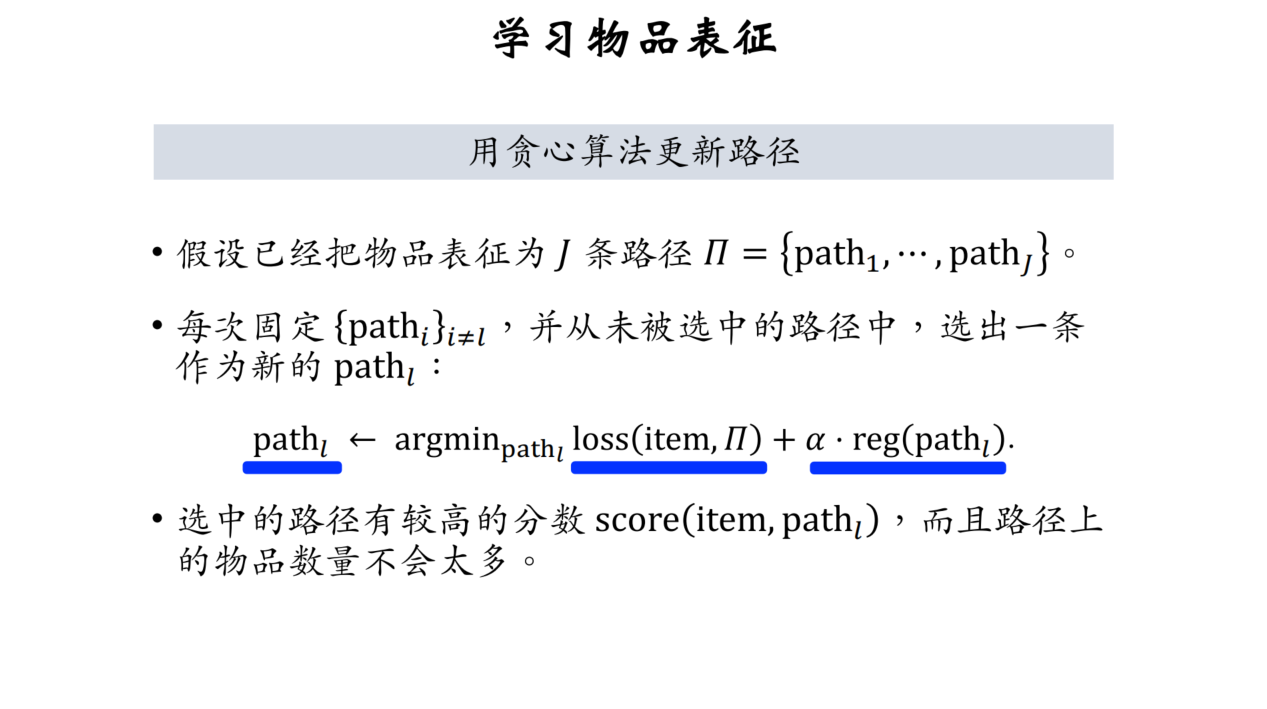

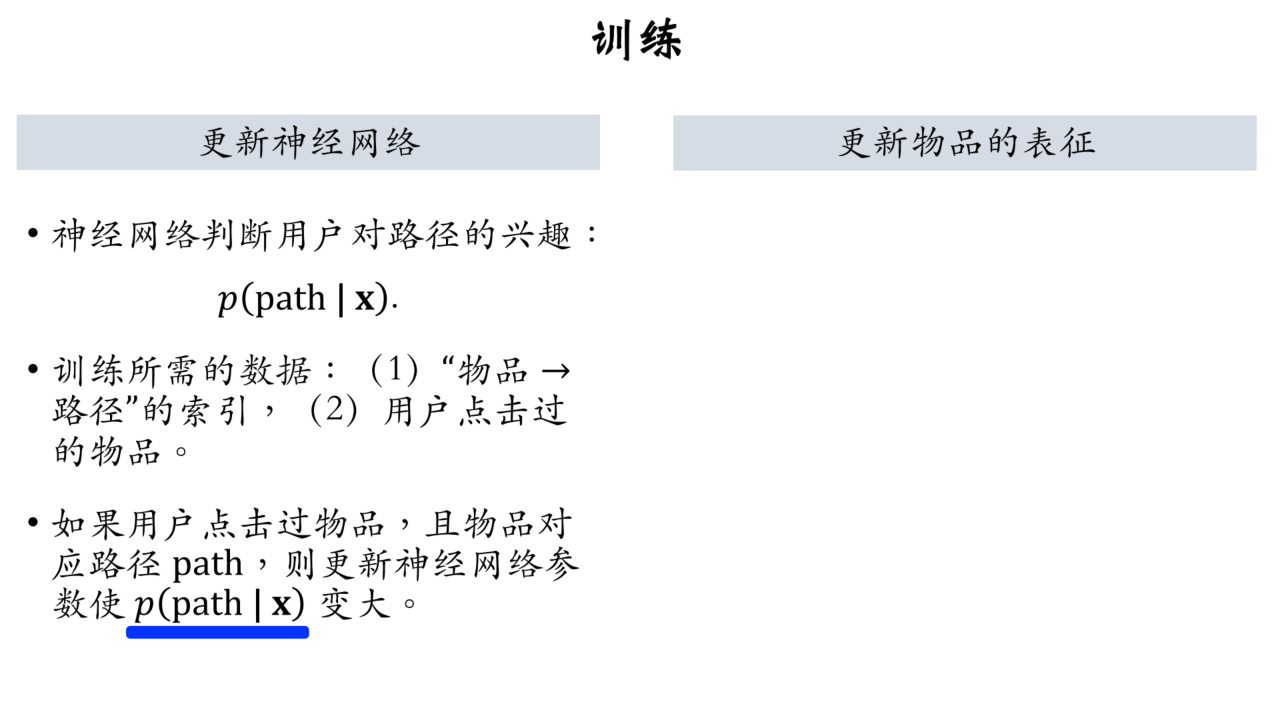

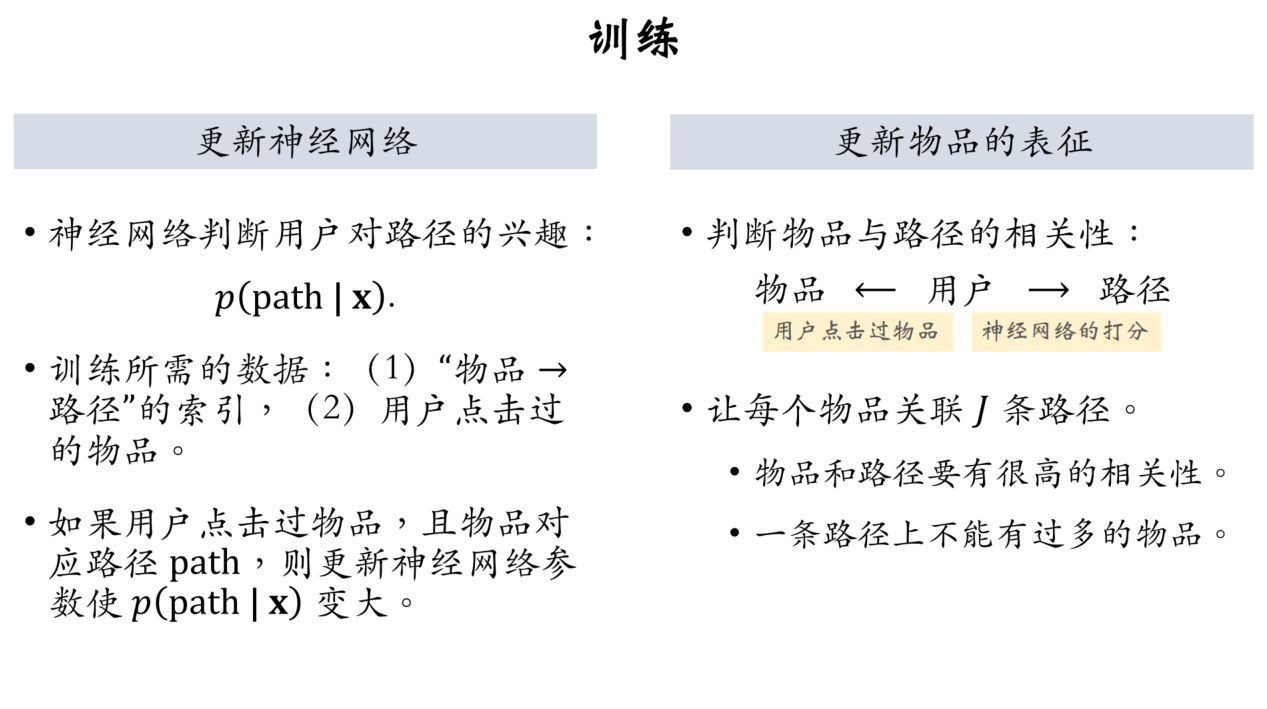

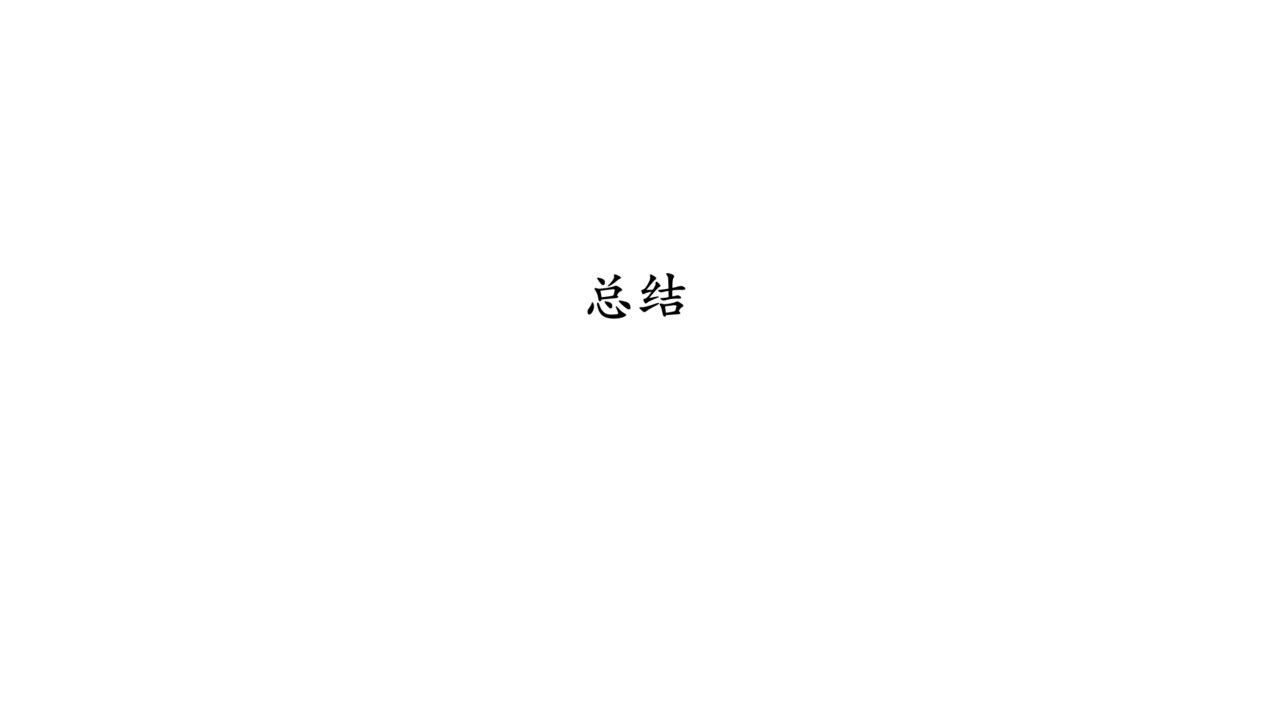

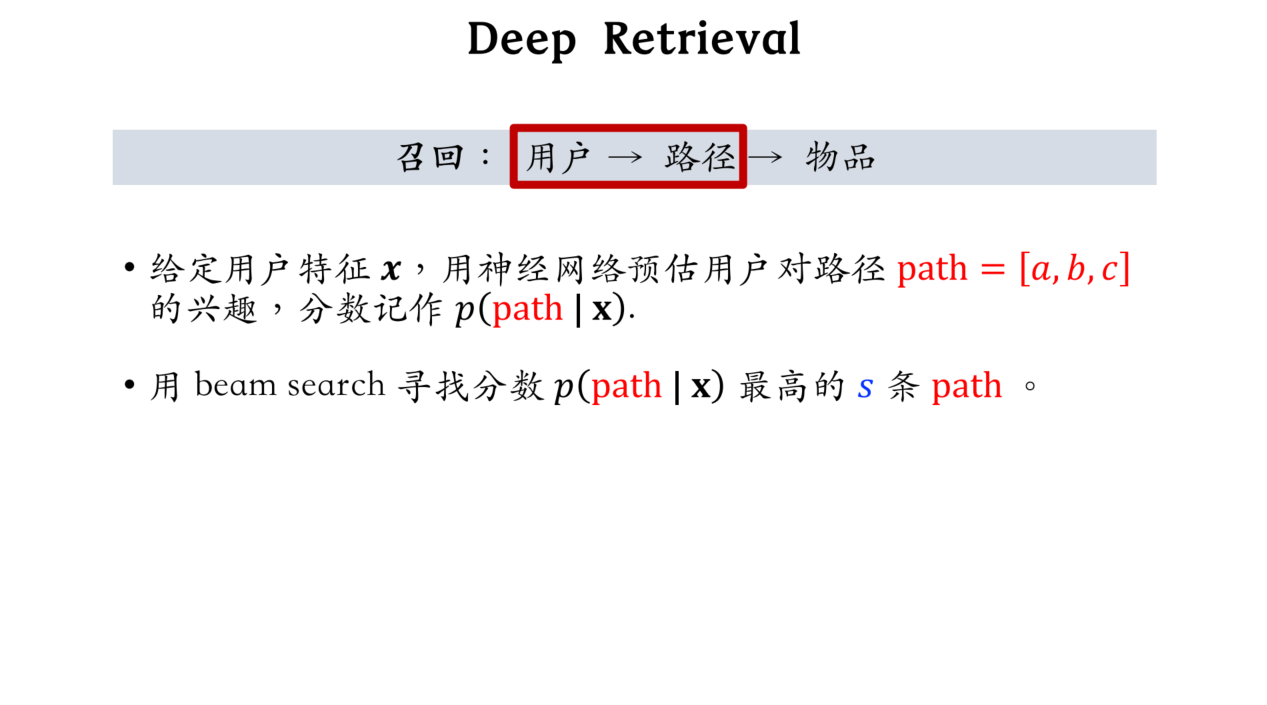

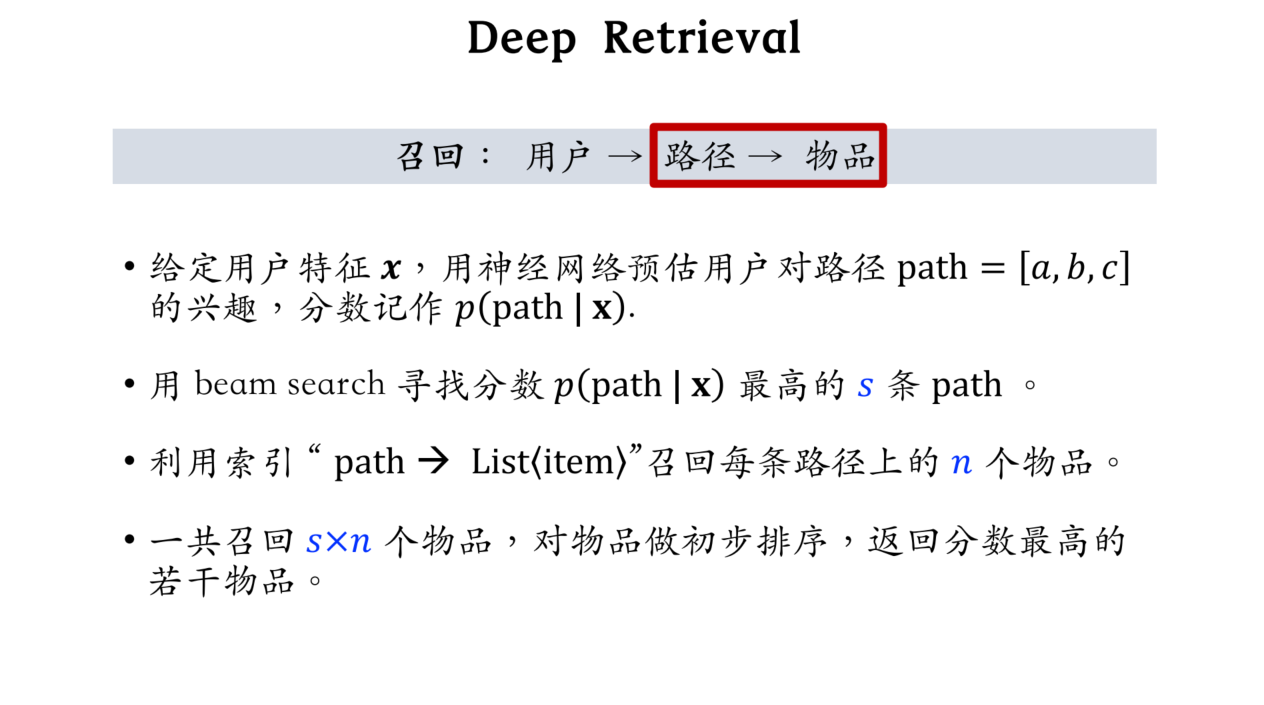

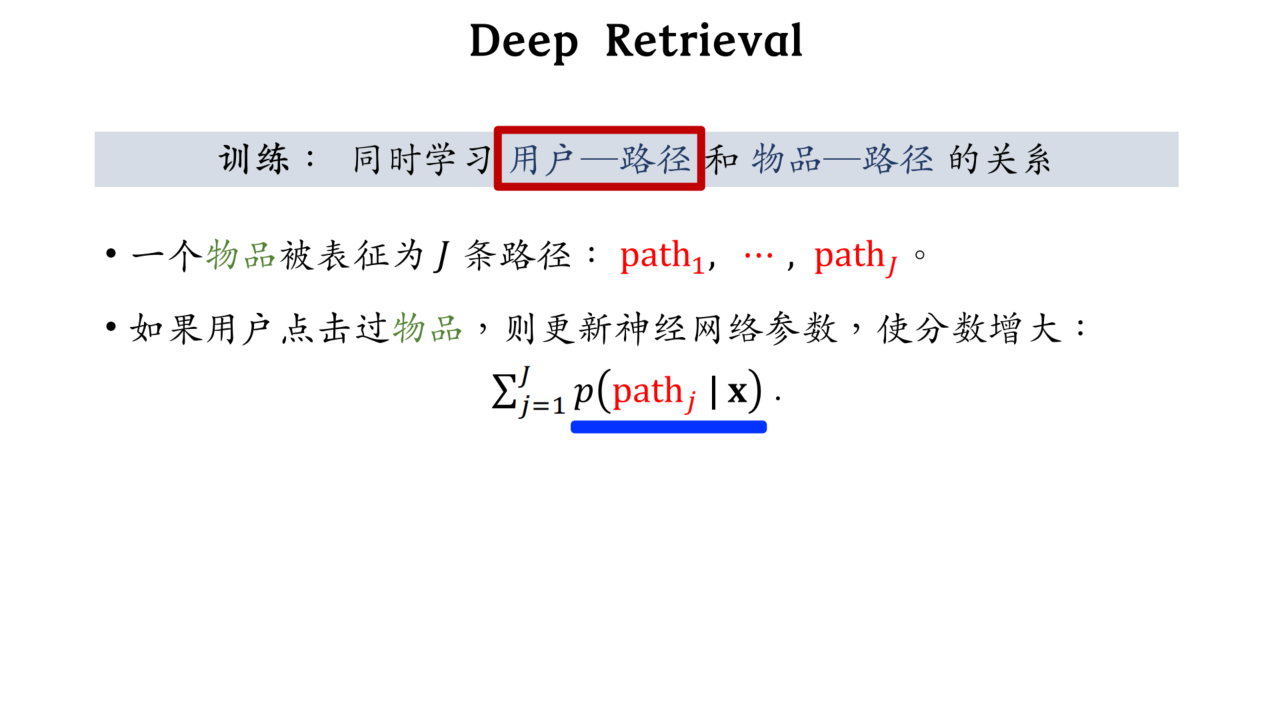

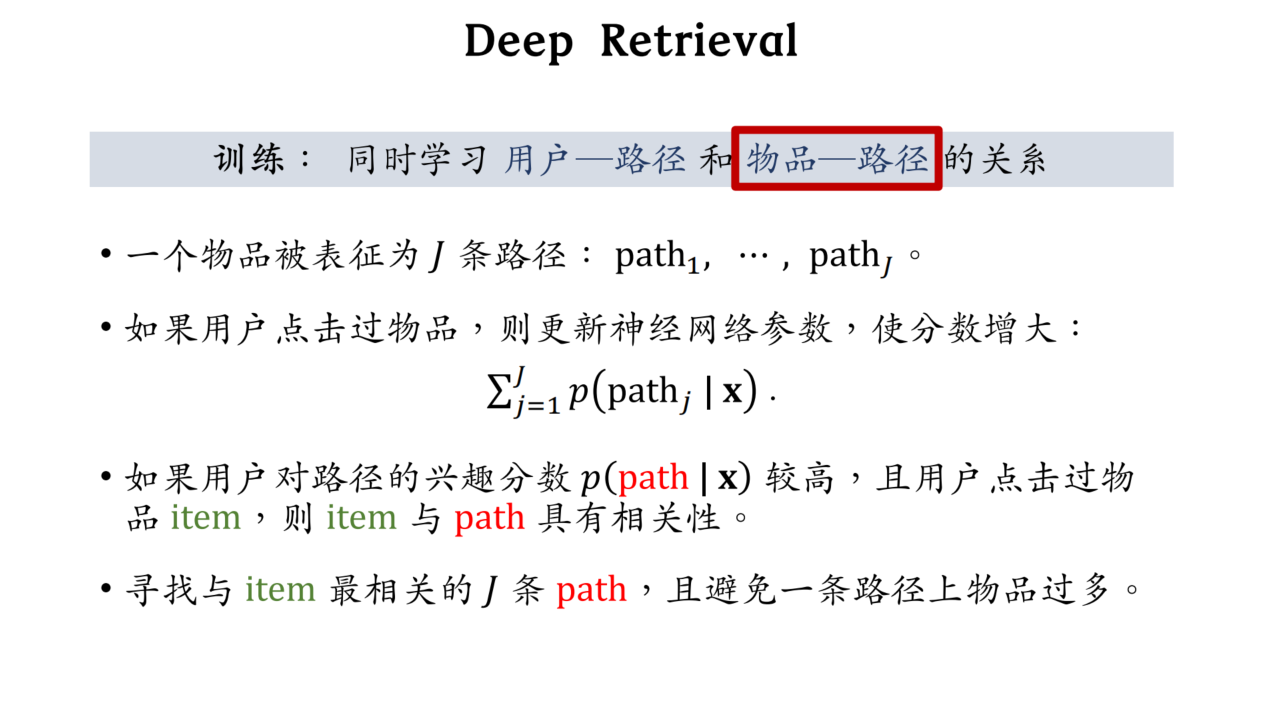

In [ ]:
## 心得

#1、为什么要用DR模型？
# 召回因为候选集个数多，一般用MIPS的思路做，这样的问题在于：1、向量最大内积模型表达 能力有限，缺少特征交互；
# 2、ANN的时候会通过聚类减小候选集(IVFAQ)，但是这个聚类建立索引的过程，跟召回模型的训练是分开的，效果肯定不好；
# 可能存在召回模型学好了，但是检索不出来的情况。

#2、TDM和DR区别
# Multi-path structure Objective中每个节点属于多个路径，而不是单个，这是因为很多item都会被归到多个类里面去。
# 比如巧克力和cake，既是food也是gift。
# 而在TDM中，每个叶子节点只能表示一个item，一个item也只能包含在一个内部节点中。

#3、优化
# 这里面item对应的路径是离散的，无法通过梯度下降去优化。Item->path的映射可以与聚类有点类似。所以用EM算法 train

#4、没有item特征
#1）structure model的probability只是用了user侧的特征，没有用item的特征；
#2）只是用了positive example来做；
#还有一点是这个模型没法用item侧的特征，类似于YouTubeDNN，属于单侧建模

#5、deep retrieval（简称DR）和TDM这一类把训练和inference结合的更好的算法；

#6、TDM 和 Deep Retrieval 论文的核心就是立足于如何构建这样一套高效的索引结构来增加检索效率，从而使得在召回中直接使用复杂模型成为可能。

#7、Deep Retrieval的优势:
#训练的时候item的露肩可以和神经网络参数用EM算法一起学习
#Deep Retrieval是end-to-end的模型，容易部署
#多对多的编码方式使得DR能学到user和item更复杂的关系

#8、Deep Retrieval为何如此优秀？
#论文提到，Deep Retrieval能如此优秀，是因为目标函数包含了softmax层，因为一开始每个物品的路径是随机初始化的，增加了优化的困难，
#因为softmax的输入是共享embeding的，使得模型一直在往正确的方向学习，最后还用了beam search，所以召回如此优秀。


#9、双塔/TDM
#1)双塔
#双塔，TDM，DR的区别准则是item是一个节点还是一条路径，以及是否取到某个非叶子节点就把下面所有的点都放进结果
#双塔+ANN虽然在现在的召回中处于霸主地位，但也有一些工作试图推翻它的统治。对于双塔来说，最大的问题就是user侧的特征和item侧的特征交互的太晚了，
#这两部分在最后一层才通过点积产生交互。但是如果能在网络前期就让用户和item交叉，对模型的性能可能有非常大的收益，即这个交互关系还需要经过一些非线性的抽象。
#FM的成功已经说明了user和item的交叉是多么重要。

#TDM
#从上面的框架出发，能更加容易的理解TDM的原理。首先TDM继承了上面的形式，让item都在叶子节点上。不过此时，由于不再使用ANN，上面三层的约束可以拿掉了，
#此时是一个可以任意深度的树。

#TDM中，最重要的设定是除叶子节点以外，父节点也有user和item交互的预估值，但这个值等于子节点中最大的值，除以当前层的归一化系数。这么说有点绕，
# 换句话说就是子节点在该层中最大，那么父节点在上一层中也最大。

#DR
#再次对比TDM的实现和我们一开始提出的基准框架，可以发现TDM继承了大部分的设定，比如item是以叶子节点的形式存在。
#而字节的DR打破了这一设定：在DR中，从上到下的一条路径代表一个item（有读者可能会说，原始结构不是没有树吗，别急，先往下看）。
# #在树中，如果不把item按在叶子节点上，就不必要出现逐层增多的形式。也就是说，既然已经让路径代表一个item了，就没有必要每层节点都不一样，
#简单起见可以设定成一个D*K方阵，有D层，每层有K个节点即可，这就是DR中的数据结构。

#https://zhuanlan.zhihu.com/p/452600618?utm_source=weibo&utm_medium=social&utm_content=snapshot&utm_oi=784704647532261376

#10、注意DR训练分2步：用户对路径的兴趣，物品item与路径path的相关性；

#11、论文
#http://arxiv.org/pdf/2007.07203.pdf


# 补充1 - DTM结构  

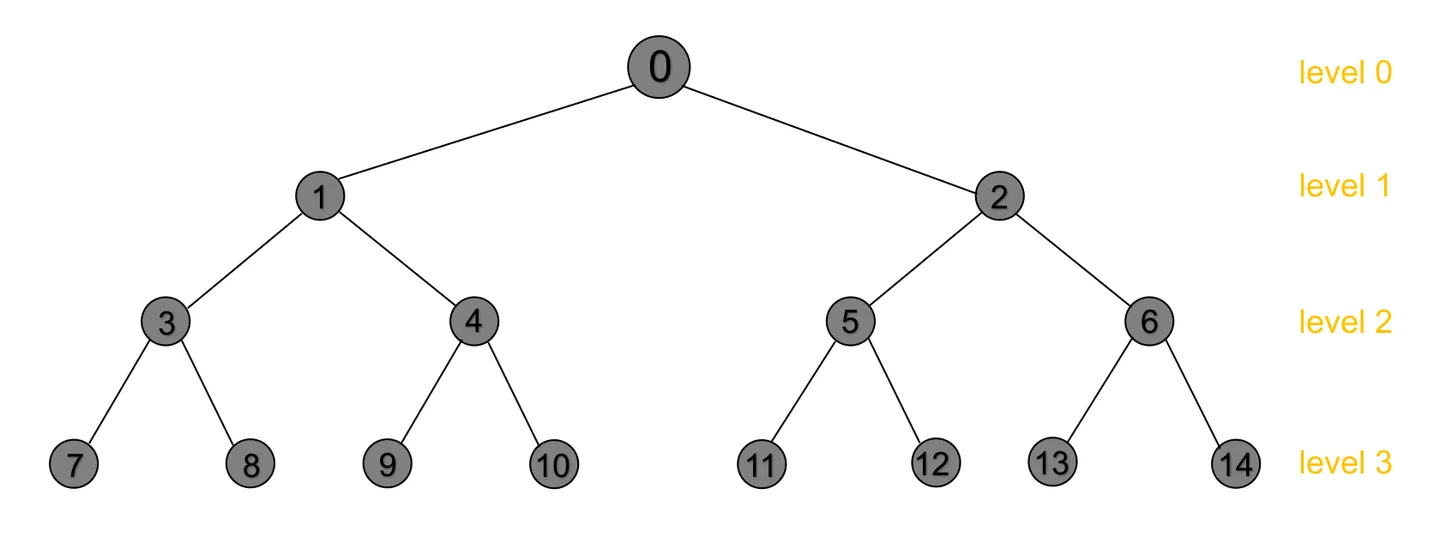  

虽然图中最底层只有 8 个叶节点，但实际场景中可能会有百万到上亿个物品，所以直接用复杂模型遍历叶节点检索是不大可行的。
论文中采用的是 beam search 的方法从根节点 (root node) 开始逐层挑选 top-K 节点，而挑选的依据正是用户对每个节点的偏好 
 ，然后将这些 top-K 节点的子节点作为下一层的候选节点，一直到最后一层。  

 样本构造：将用户交互过的物品 (叶节点) 设为正样本，由于树结构已预先确定，那么每个叶节点的祖先节点也就确定了，而根据上面的最大堆性质，
 正样本叶节点的祖先节点也同样为正样本，同时在各层随机采样一些除正样本以外的节点作为负样本。



# 补充2 - Deep Retrieval  

Deep Retrieval 的核心卖点和 TDM 系列差不多，即在大规模召回中直接使用复杂模型，因而两者总免不了被拿来作比较。TDM 系列为了能快速检索引入了树作为索引结构，
而 DR 中的索引结构是一个K*D的矩阵，总共有D层，每层K个节点，见论文中的图 (a)：

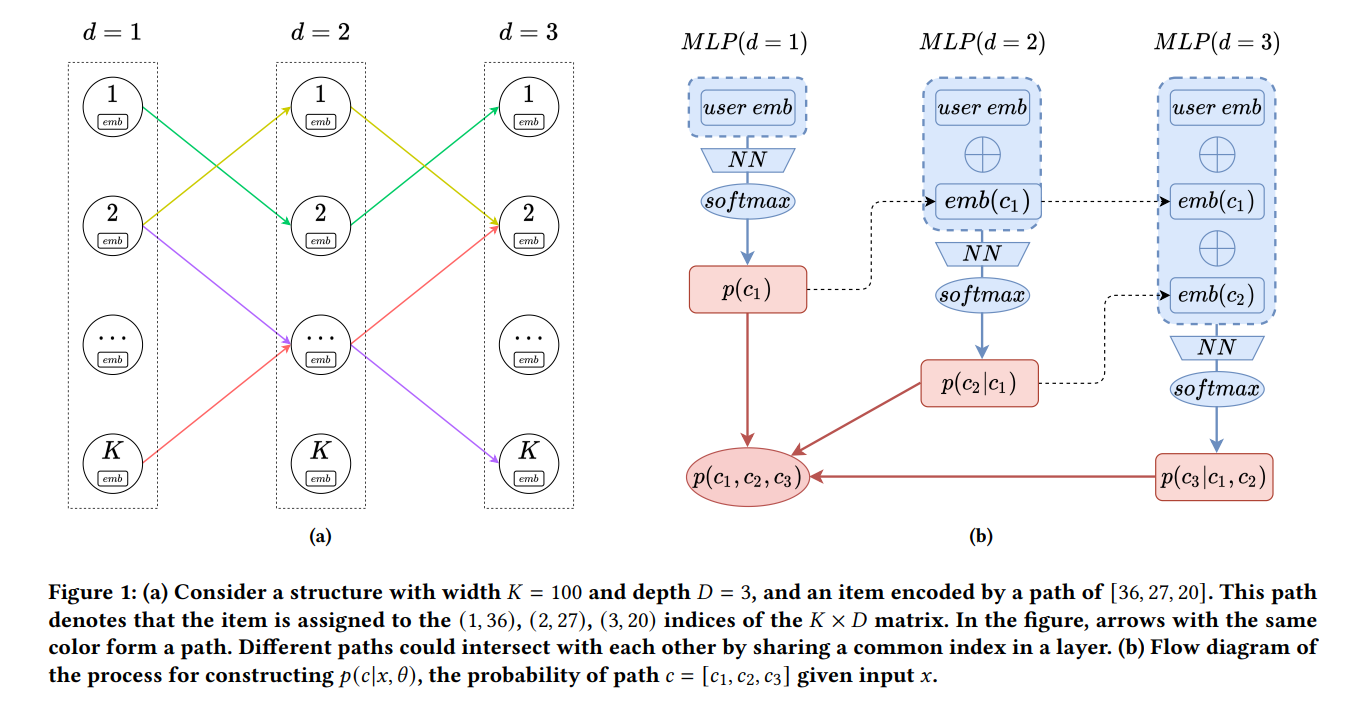  


在检索的时候同样使用了 beam search，从最左侧的一层开始使用 user embed 作为输入，每一层选择 top-B 的节点，最后得到 top-B 的 path，再通过映射函数找到 path 对应的物品。 

DR如何定义目标函数？  
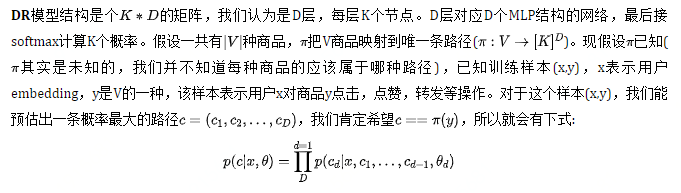